#%%[markdown]

 ## Meta-Learnig via RNNs in weight space
 Use a RNN for map data to a sequence of weights
 - The RNN is a a linear state space model with A and B: theta_{t+1} = A theta_t + B x_t
 - This should work on irregular time series data, since the theta_t is decoded and evaluated between (0,1)
 - The loss function compares the latent space'd decoded output to the ground thruth
# ToDo:
 - [] Why is my cros-entropy so bad, and optax so good ?
 - [] Try the Neural CDE irregular dataset
 - [] Add delta_t in front of the A matrix

In [ ]:
#%%

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)
# config.update("jax_enable_x64", True)
# from jax.experimental import checkify

## Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import jax.numpy as jnp

## Import jax partial
from jax.tree_util import Partial

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx

# import matplotlib.pyplot as plt
from neuralhub import *
from loaders import TrendsDataset, MNISTDataset
from selfmod import NumpyLoader, setup_run_folder, torch

import optax
import time

## Set seaborn style to talk
import seaborn as sb
sb.set_context("poster")

Available devices: [CudaDevice(id=0)]

############# Contextual Self-Modulation #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

SEED = 2025
main_key = jax.random.PRNGKey(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Model hps
mlp_hidden_size = 16*2
mlp_depth = 2
rnn_inner_dims = []
nb_rnn_layers = len(rnn_inner_dims) + 1

## Optimiser hps
init_lr = 1e-4

## Training hps
print_every = 10
nb_epochs = 10*9*4*2
batch_size = 128*4
grounding_length = 300       ## The length of the grounding pixel for the autoregressive digit generation
full_matrix_A = True        ## Whether to use a full matrix A or a diagonal one
use_theta_prev = False      ## Whether to use the previous pevious theta in the computation of the next one
classification = False       ## True for classification, False for reconstruction
mini_res_mnist = 1
traj_train_prop = 1.0       ## Proportion of steps to sample to train each time series
weights_lim = 5e-1         ## Limit the weights of the root model to this value
nb_recons_loss_steps = 40        ## Number of steps to sample for the reconstruction loss
train_strategy = "flip_coin"     ## "flip_coin", "teacher_forcing", "always_true"
use_mse_loss = False
run_mnist = True
print("==== Classification Task ====") if classification else print("==== Reconstruction Task ====")

train = False
data_folder = "./data/" if train else "../../data/"

# run_folder = "./runs/250208-184005-Test/" if train else "./"
run_folder = None if train else "./"

==== Reconstruction Task ====


In [ ]:
#%%

### Create and setup the run folder
if run_folder==None:
    run_folder = make_run_folder('./runs/')
else:
    print("Using existing run folder:", run_folder)
_, checkpoints_folder, _ = setup_run_folder(run_folder, os.path.basename(__file__), None)

## Copy loaders script to the run folder
os.system(f"cp loaders.py {run_folder}");

Using existing run folder: ./
 Backed up run script and module files 


cp: 'main_ssm.py' and './main_ssm.py' are the same file
cp: '/home/gb21553/Projects/NeuralHub/examples/time-series/runs/250215-020741-HyperGenius*/selfmod' and './selfmod' are the same file
cp: 'loaders.py' and './loaders.py' are the same file


 #### MNIST Dataset ####
Training sequence length: 784
Images shape: (512, 784, 1)
Labels shape: (512,)
Min and Max in the dataset: -1.0 1.0


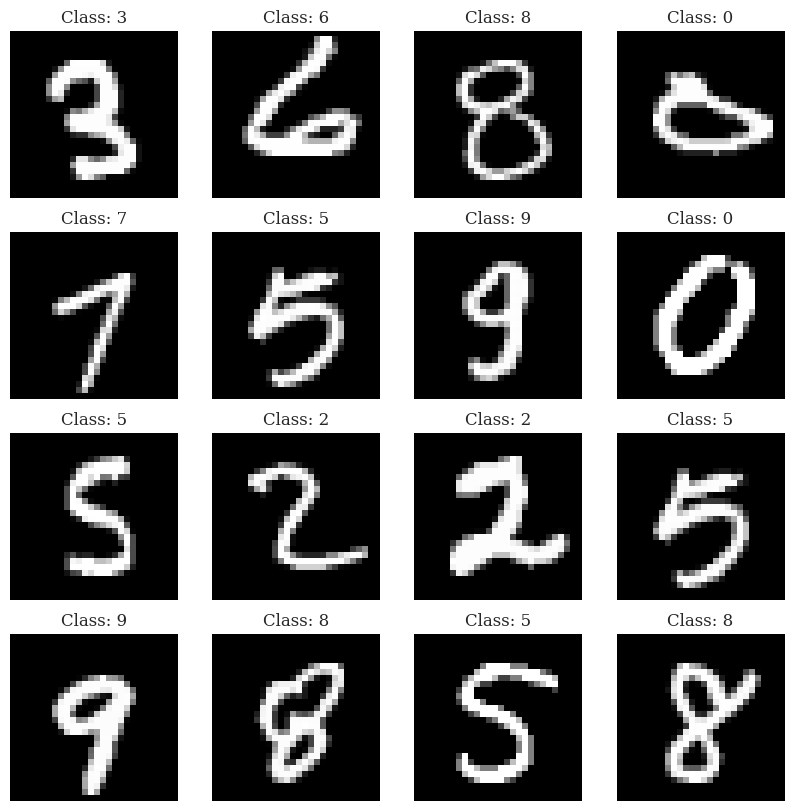

In [ ]:
#%%

if run_mnist:
    # ### MNIST Classification (From Sacha Rush's Annotated S4)
    print(" #### MNIST Dataset ####")
    trainloader = NumpyLoader(MNISTDataset(data_folder+"data/", data_split="train", mini_res=mini_res_mnist, traj_prop=traj_train_prop), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=24)
    testloader = NumpyLoader(MNISTDataset(data_folder+"data/", data_split="test", mini_res=mini_res_mnist, traj_prop=1.0),
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=24)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size
    print("Training sequence length:", seq_length)
else:
    print(" #### Trends (Synthetic Control) Dataset ####")
    ## ======= below to run the easy Trends dataset instead!
    trainloader = NumpyLoader(TrendsDataset(data_folder+"trends/", skip_steps=1, traj_prop=traj_train_prop), 
                              batch_size=batch_size if batch_size<600 else 600, 
                              shuffle=True)
    testloader = NumpyLoader(TrendsDataset(data_folder+"trends/", skip_steps=1, traj_prop=1.0), 
                             batch_size=batch_size if batch_size<600 else 600,
                             shuffle=True)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size

batch = next(iter(testloader))
(images, times), labels = batch
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

print("Min and Max in the dataset:", jnp.min(images), jnp.max(images))

## Plot a few samples, along with their labels as title in a 4x4 grid (chose them at random)
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True)
colors = ['r', 'g', 'b', 'c', 'm', 'y']
res = 28 // mini_res_mnist
for i in range(4):
    for j in range(4):
        idx = np.random.randint(0, images.shape[0])
        if run_mnist:
            axs[i, j].imshow(images[idx].reshape((res, res)), cmap='gray')
        else:
            axs[i, j].plot(images[idx], color=colors[labels[idx]])
        axs[i, j].set_title(f"Class: {labels[idx]}", fontsize=12)
        axs[i, j].axis('off')

In [ ]:
# %%

class RootMLP(eqx.Module):
    network: eqx.Module
    props: any      ## Properties of the network

    def __init__(self, input_dim, output_dims, hidden_size, depth, activation=jax.nn.tanh, key=None):
        key = key if key is not None else jax.random.PRNGKey(0)
        keys = jax.random.split(key, num=2)

        final_activation = jax.nn.tanh if run_mnist else lambda x:x
        self.network = eqx.nn.MLP(input_dim, output_dims, hidden_size, depth, activation, final_activation=final_activation, key=keys[0])
        # self.network = eqx.nn.MLP(input_dim, output_dims, hidden_size, depth, activation, key=keys[0])

        self.props = (input_dim, output_dims, hidden_size, depth, activation)

    def __call__(self, t):
        return self.network(t)


# ## Define model and loss function for the learner
class Ses2Seq(eqx.Module):
    """ Sequence to sequence model which takes in an initial latent space """
    As: jnp.ndarray
    Bs: jnp.ndarray
    thetas: jnp.ndarray
    # alpha: jnp.ndarray

    root_utils: list
    inference_mode: bool
    data_size: int

    def __init__(self, 
                 data_size, 
                 width, 
                 depth, 
                 activation="relu",
                 rnn_inner_dims=[],
                 key=None):

        keys = jax.random.split(key, num=3)
        builtin_fns = {"relu":jax.nn.relu, "tanh":jax.nn.tanh, 'softplus':jax.nn.softplus}
        # out_size = nb_classes if classification else data_size
        if classification:
            out_size = nb_classes
        else:
            if use_mse_loss:
                out_size = data_size
            else:      ## NLL loss
                out_size = 2*data_size

        rnn_in_layers = [data_size] + rnn_inner_dims
        rnn_out_layers = rnn_inner_dims + [out_size]
        B_out_shapes = rnn_in_layers[:-1] + [data_size]
        keys = jax.random.split(keys[2], num=nb_rnn_layers)
        thetas = []
        root_utils = []
        As = []
        Bs = []
        for i in range(nb_rnn_layers):
            root = RootMLP(1, rnn_out_layers[i], width, depth, builtin_fns[activation], key=keys[i])
            params, static = eqx.partition(root, eqx.is_array)
            weights, shapes, treedef = flatten_pytree(params)
            root_utils.append((shapes, treedef, static, root.props))
            thetas.append(weights)

            latent_size = weights.shape[0]
            A = jnp.eye(latent_size, latent_size) if full_matrix_A else jnp.ones((latent_size,))
            if use_theta_prev:
                A = A*0.
            As.append(A)
            Bs.append(jnp.zeros((latent_size, B_out_shapes[i])))

        self.root_utils = root_utils
        self.thetas = thetas
        self.As = As
        self.Bs = Bs

        self.inference_mode = False     ## Change to True to use the model autoregressively
        self.data_size = data_size
        # self.alpha = jnp.array([0.0])

    def __call__(self, xs, ts, aux):
        """ xs: (batch, time, data_size)
            theta: (latent_size)
            """
        alpha, key = aux

        def forward(xs_, ts_, k_):
            ## 1. Fine-tune the latents weights on the sequence we have

            ## Call the JAX scan across layers
            nb_rnn_layers = len(self.thetas)
            layer_keys = jax.random.split(k_, nb_rnn_layers)
            xs_orig = xs_

            for i in range(nb_rnn_layers):
                keys = jax.random.split(layer_keys[i], xs_.shape[0])
                final_layer = i==nb_rnn_layers-1

                ## Do a partial on f
                def f(carry, input_signal):
                    thet, x_prev, t_prev, x_prev_prev, thet_prev = carry
                    x_true, t_curr, key_ = input_signal
                    delta_t = t_curr - t_prev

                    A = self.As[i]
                    B = self.Bs[i]
                    root_utils = self.root_utils[i]

                    # A = jnp.clip(self.As[i], -0.001, 0.001)
                    # B = jnp.clip(self.Bs[i], -0.001, 0.001)

                    if self.inference_mode:
                        x_t = jnp.where(t_curr<grounding_length/seq_length, x_true, x_prev)
                    else:
                        if train_strategy == "flip_coin":
                            x_t = jnp.where(jax.random.bernoulli(key_, 0.25), x_true, x_prev)
                        elif train_strategy == "teacher_forcing":
                            x_t = alpha*x_true + (1-alpha)*x_prev
                        else:
                            x_t = x_true

                    if full_matrix_A:
                        # jax.debug.print("x_t and x_prev_prev: {} {}", x_t, x_prev_prev)

                        # checkify.check(jnp.isnan(x_t).any(), "x_t is nan")
                        # checkify.check(jnp.isnan(x_prev_prev).any(), "x_prev_prev is nan")
                        # checkify.check(jnp.isnan(thet).any(), "theta_next is nan")

                        # print("x_t and x_prev_prev: ", x_t.shape, x_prev_prev.shape, B.shape)
                        # thet_next = A@thet + B@(x_t)
                        # thet_next = A@(thet - thet_prev)/(delta_t) + B@(x_t - x_prev_prev)/(delta_t)     ## Promising !
                        # thet_next = A@thet + B@jnp.square(x_t - x_prev_prev)/(delta_t)     ## Promising !

                        # thet_next = thet + A@(thet_prev*delta_t) + B@(x_t - x_prev_prev)/(delta_t)     ## Promising !
                        # thet_next = thet + A@(thet_prev/delta_t) + B@(x_t - x_prev_prev)/(delta_t)     ## Promising !

                        if use_theta_prev:
                            thet_next = thet + A@(thet_prev) + B@(x_t - x_prev_prev)     ## Promising !
                        else:
                            thet_next = A@(thet) + B@(x_t - x_prev_prev)     ## Promising !

                    else:
                        thet_next = A*thet + delta_t*B@x_t

                    ## 2. Decode the latent space
                    thet_next = jnp.clip(thet_next, -weights_lim, weights_lim)
                    # jax.debug.print("Smallest and biggest values in thet_next: {} {}", jnp.min(thet_next), jnp.max(thet_next))

                    shapes, treedef, static, _ = root_utils
                    params = unflatten_pytree(thet_next, shapes, treedef)
                    root_fun = eqx.combine(params, static)
                    x_next = root_fun(t_curr+delta_t)

                    x_next_mean = x_next[:x_true.shape[0]]

                    return (thet_next, x_next_mean, t_curr, x_prev, thet), (x_next, )

                sup_signal = xs_ if not final_layer else xs_orig        ## Supervisory signal
                # print("Shapes of thetas:", xs_.shape)
                # print("Current layer:", i)
                _, (xs_, ) = jax.lax.scan(f, (self.thetas[i], sup_signal[0], -ts_[1:2], sup_signal[0], self.thetas[i]), (sup_signal, ts_[:, None], keys))

            return xs_

        ## Batched version of the forward pass
        ks = jax.random.split(key, xs.shape[0])
        return eqx.filter_vmap(forward)(xs, ts, ks)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=2)

model = Ses2Seq(data_size=data_size, 
                width=mlp_hidden_size, 
                depth=mlp_depth, 
                activation="relu", 
                rnn_inner_dims=rnn_inner_dims,
                key=model_keys[0])

# if train_in_inference_mode:
#     model = eqx.tree_at(lambda m:m.inference_mode, model, True)
untrained_model = model
## Print the total number of learnable paramters in the model components
print(f"Number of learnable parameters in the root network: {count_params((model.thetas,))/1000:3.1f} k")
print(f"Number of learnable parameters in the seqtoseq: {count_params((model.As, model.Bs))/1000:3.1f} k")
print(f"Number of learnable parameters in the model: {count_params(model)/1000:3.1f} k")

Number of learnable parameters in the root network: 1.2 k
Number of learnable parameters in the seqtoseq: 1407.8 k
Number of learnable parameters in the model: 1409.0 k


In [ ]:
# %%

def loss_fn(model, batch, utils):
    (X_true, times), X_labels = batch       ## X: (batch, time, data_size) - Y: (batch, num_classes)

    if classification:
        ## Categorical cross-entropy loss with optax
        X_classes = model(X_true, times, utils)     ## Y_hat: (batch, time, num_classes) 
        pred_logits = X_classes[:, -1, :]   ## We only care about the last prediction: (batch, num_classes)
        losses_c = optax.softmax_cross_entropy_with_integer_labels(pred_logits, X_labels)
        loss = jnp.mean(losses_c)

        ## Calculate accuracy
        acc = jnp.mean(jnp.argmax(pred_logits, axis=-1) == X_labels)
        return loss, (acc,)

    else:
        ## Make a reconstruction loss
        X_recons = model(X_true, times, utils)     ## Y_hat: (batch, time, data_size) 
        alpha, key = utils

        ## Randomly sample 2 points in the sequence to compare
        # indices = jax.random.randint(key, (2,), 0, X_true.shape[1])
        # loss_r = optax.l2_loss(X_recons[:, indices], X_true[:, indices])

        batch_size, nb_timesteps = X_true.shape[0], X_true.shape[1]
        indices_0 = jnp.arange(batch_size)
        indices_1 = jax.random.randint(key, (batch_size, nb_recons_loss_steps), 0, nb_timesteps)

        X_recons_ = jnp.stack([X_recons[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
        X_true_ = jnp.stack([X_true[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)

        if use_mse_loss:
            loss_r = optax.l2_loss(X_recons_, X_true_)
        else: ## Use the negative log likelihood loss
            means = X_recons_[:, :, :data_size]
            stds = jnp.clip(jax.nn.softplus(X_recons_[:, :, data_size:]), 1e-6, 1)
            loss_r = jnp.log(stds) + 0.5*((X_true_ - means)/stds)**2

        loss = jnp.mean(loss_r)
        return loss, (loss,)


@eqx.filter_jit
def train_step(model, batch, opt_state, key):
    # print('\nCompiling function "train_step" ...')

    (loss, aux_data), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, batch, key)

    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss, aux_data

@eqx.filter_jit
def alpha_schedule(epoch, nb_epochs):
    """ Compute the schedule for the alpha parameter 
    At epoch 0, alpha = 1.0
    At epoch nb_epochs, alpha = 0.0
    Decreases smoothly from 1.0 to 0.0. along a sigmoid whose flatness if controlled by nb_epochs
    """
    steepness = 10 / nb_epochs
    midpoint = nb_epochs / 2
    return 1.0 - (1 / (1 + jnp.exp(-steepness * (epoch - midpoint))))

## Plot the alpha schedule
if train_strategy == "teacher_forcing":
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    epochs = jnp.arange(nb_epochs)
    alpha_vals = eqx.filter_vmap(alpha_schedule, in_axes=(0,None))(epochs, nb_epochs)
    ax.plot(epochs, alpha_vals, "g-")
    ax.set_title("Alpha schedule")
    ax.set_xlabel("Epoch")
    plt.draw();

In [ ]:
#%%

alpha = 1.

if train:
    # sched = optax.exponential_decay(init_value=init_lr, transition_steps=10, decay_rate=0.99)
    # opt = optax.adam(sched)
    if classification:
        opt = optax.adabelief(init_lr)
    else:
        num_steps = trainloader.num_batches * nb_epochs
        bd_scales = {int(num_steps/3):0.4, int(num_steps*2/3):0.4}
        sched = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=bd_scales)
        # sched = init_lr

        opt = optax.chain(optax.clip(1e-7), optax.adabelief(sched))       ## Clip the gradients to 1.0
        # opt = optax.adabelief(sched)

    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    train_key, _ = jax.random.split(main_key)

    losses = []
    losses_epoch = []

    print(f"\n\n=== Beginning Training ... ===")
    start_time = time.time()

    for epoch in range(nb_epochs):

        nb_batches = 0.
        loss_sum = 0.

        alpha = alpha_schedule(epoch, nb_epochs)

        for i, batch in enumerate(trainloader):
            train_key, _ = jax.random.split(train_key)
            model, opt_state, loss, aux = train_step(model, batch, opt_state, (alpha, train_key))

            loss_sum += loss
            nb_batches += 1

            losses.append(loss)

        loss_epoch = loss_sum/nb_batches
        losses_epoch.append(loss_epoch)

        if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
            if classification:
                acc, = aux
                print(f"    Epoch: {epoch:-5d}      Cross-Ent Loss: {loss_epoch:.6f}      Accuracy: {acc*100:.2f}%", flush=True)
            else:
                aux_loss, = aux
                if use_mse_loss:
                    print(f"    Epoch: {epoch:-5d}      MSELoss: {loss_epoch:.6f}", flush=True)
                else:
                    print(f"    Epoch: {epoch:-5d}      NLL Loss: {loss_epoch:.6f}", flush=True)

            eqx.tree_serialise_leaves(checkpoints_folder+f"model_{epoch}.eqx", model)
            np.save(run_folder+"losses.npy", np.array(losses))

            ## Only save the best model with the lowest loss
            if epoch>0 and loss_epoch<min(losses_epoch[:-1]):
                eqx.tree_serialise_leaves(run_folder+"model.eqx", model)

    wall_time = time.time() - start_time
    time_in_hmsecs = seconds_to_hours(wall_time)
    print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

    print(f"Training Complete, saving model to folder: {run_folder}")
    if losses[-1]<min(losses_epoch[:-1]):
        eqx.tree_serialise_leaves(run_folder+"model.eqx", model)
    np.save(run_folder+"losses.npy", np.array(losses))

else:
    model = eqx.tree_deserialise_leaves(run_folder+"model.eqx", model)

    try:
        losses = np.load(run_folder+"losses.npy")
    except:
        losses = []

    print("Model loaded from folder")

Model loaded from folder


In [ ]:
# %%

if os.path.exists(run_folder+"losses.npy"):
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    clean_losses = np.array(losses)
    epochs = np.arange(len(losses))

    ax = sbplot(epochs, clean_losses, label="All losses", x_label='Train Steps', y_label='Loss', ax=ax, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

    clean_losses = np.where(clean_losses<np.percentile(clean_losses, 96), clean_losses, np.nan)
    ## Plot a second plot with the outliers removed
    ax2 = sbplot(epochs, clean_losses, label="96th Percentile", x_label='Train Steps', y_label='Loss', ax=ax2, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

    plt.legend()
    plt.draw();
    plt.savefig(run_folder+"loss.png", dpi=100, bbox_inches='tight')

else: ## Attempt to parse and collect losses from the nohup.log file
    try:
        with open(run_folder+"nohup.log", 'r') as f:
            lines = f.readlines()
        losses = []
        loss_name = "MSELoss" if use_mse_loss else "NLL Loss"
        for line in lines:
            if loss_name in line:
                loss = float(line.split(loss_name+": ")[1].strip())
                losses.append(loss)

        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ## Filter outlier vales and retain the rest
        clean_losses = np.array(losses)
        epochs = np.arange(len(losses))

        ax = sbplot(epochs, clean_losses, label="All losses", x_label='Train Steps', y_label='Loss', ax=ax, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

        clean_losses = np.where(clean_losses<np.percentile(clean_losses, 96), clean_losses, np.nan)
        ## Plot a second plot with the outliers removed
        ax2 = sbplot(epochs, clean_losses, label="96th Percentile", x_label='Train Steps', y_label='Loss', ax=ax2, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

        plt.legend()
        plt.draw();
        plt.savefig(run_folder+"loss.png", dpi=100, bbox_inches='tight')
    except:
        print("No losses found in the nohup.log file")

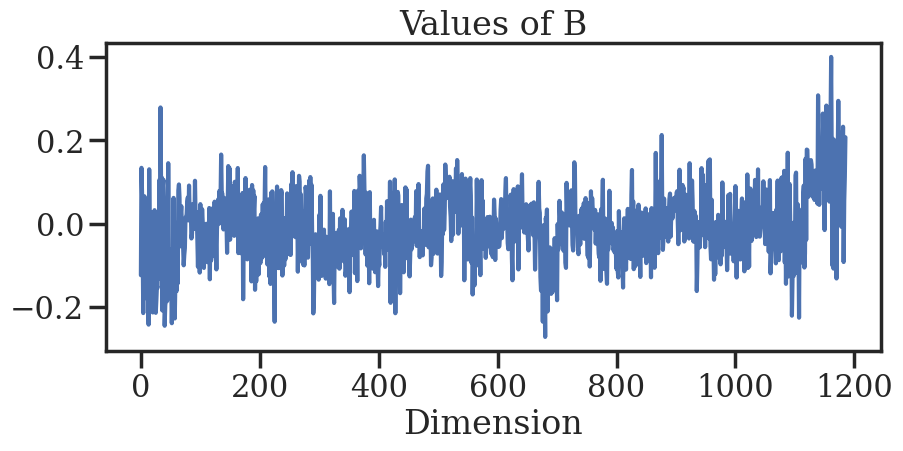

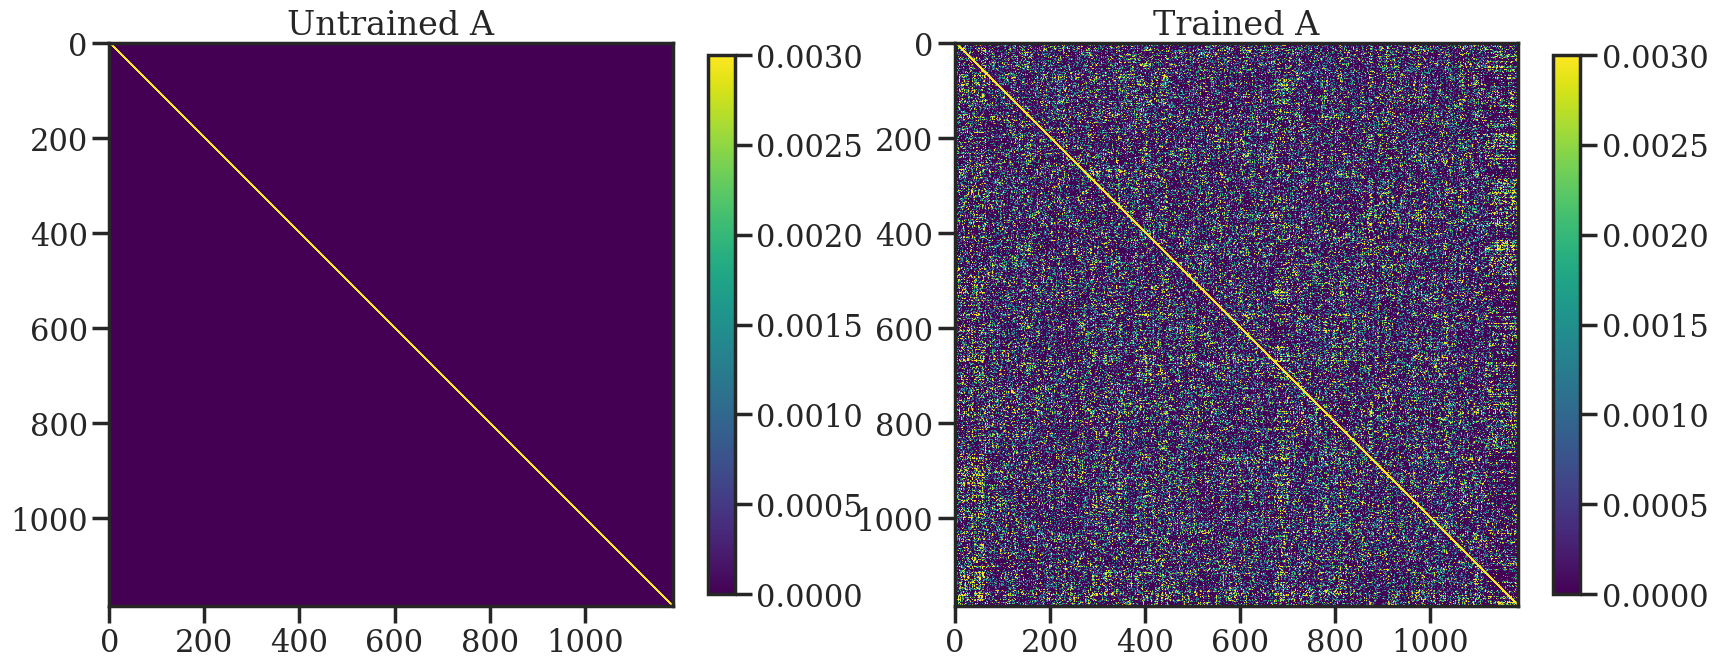

In [ ]:
# %%

## Print the value of alpha
# print("Alpha before training: (no teacher forcing)", 0.)
# print("Alpha after training:", model.alpha)

## Let's visualise the distribution of values along the main diagonal of A and theta
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
if full_matrix_A:
    axs[0].hist(jnp.diag(model.As[0], k=0), bins=100)
else:
    axs[0].hist(model.As[0], bins=100)

axs[0].set_title("Histogram of diagonal values of A (first layer)")

axs[1].hist(model.thetas[0], bins=100, label="After Training")
axs[1].hist(untrained_model.thetas[0], bins=100, alpha=0.5, label="Before Training", color='r')
axs[1].set_title(r"Histogram of $\theta_0$ values")
plt.legend();
plt.draw();
plt.savefig(run_folder+"A_theta_histograms.png", dpi=100, bbox_inches='tight')

## PLot all values of B in a lineplot (all dimensions)
if not isinstance(model.Bs[0], eqx.nn.Linear):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(model.Bs[0], label="Values of B")
    ax.set_title("Values of B")
    ax.set_xlabel("Dimension")
    plt.draw();
    plt.savefig(run_folder+"B_values.png", dpi=100, bbox_inches='tight')

if full_matrix_A:
    ## Print the untrained and trained matrices A as imshows with same range
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    # min_val = min(jnp.min(model.A), jnp.min(untrained_model.A))
    # max_val = max(jnp.max(model.A), jnp.max(untrained_model.A))
    min_val = -0.00
    max_val = 0.003

    img = axs[0].imshow(untrained_model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[0].set_title("Untrained A")
    plt.colorbar(img, ax=axs[0], shrink=0.7)

    img = axs[1].imshow(model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[1].set_title("Trained A")
    plt.colorbar(img, ax=axs[1], shrink=0.7)
    plt.draw();
    plt.savefig(run_folder+"A_matrices.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's evaluate the model on the test set
accs = []
mses = []
test_key, _ = jax.random.split(main_key)
for i, batch in enumerate(testloader):
    test_key, _ = jax.random.split(test_key)
    (X_true, times), X_labels = batch

    if classification:
        X_classes = model(X_true, times, (alpha, test_key))
        pred_logits = X_classes[:, -1, :]   ## We only care about the last prediction: (batch, num_classes)
        acc = jnp.mean(jnp.argmax(pred_logits, axis=-1) == X_labels)
        accs.append(acc)

    else:
        X_recons = model(X_true, times, (alpha, test_key))
        if not use_mse_loss:
            X_recons = X_recons[:, :, :data_size]
        mse = jnp.mean((X_recons - X_true)**2)
        mses.append(mse)

if classification:
    print(f"Mean accuracy on the test set: {np.mean(accs)*100:.2f}%")
else:
    print(f"Mean MSE on the test set: {np.mean(mses):.6f}")

Mean MSE on the test set: 0.083580


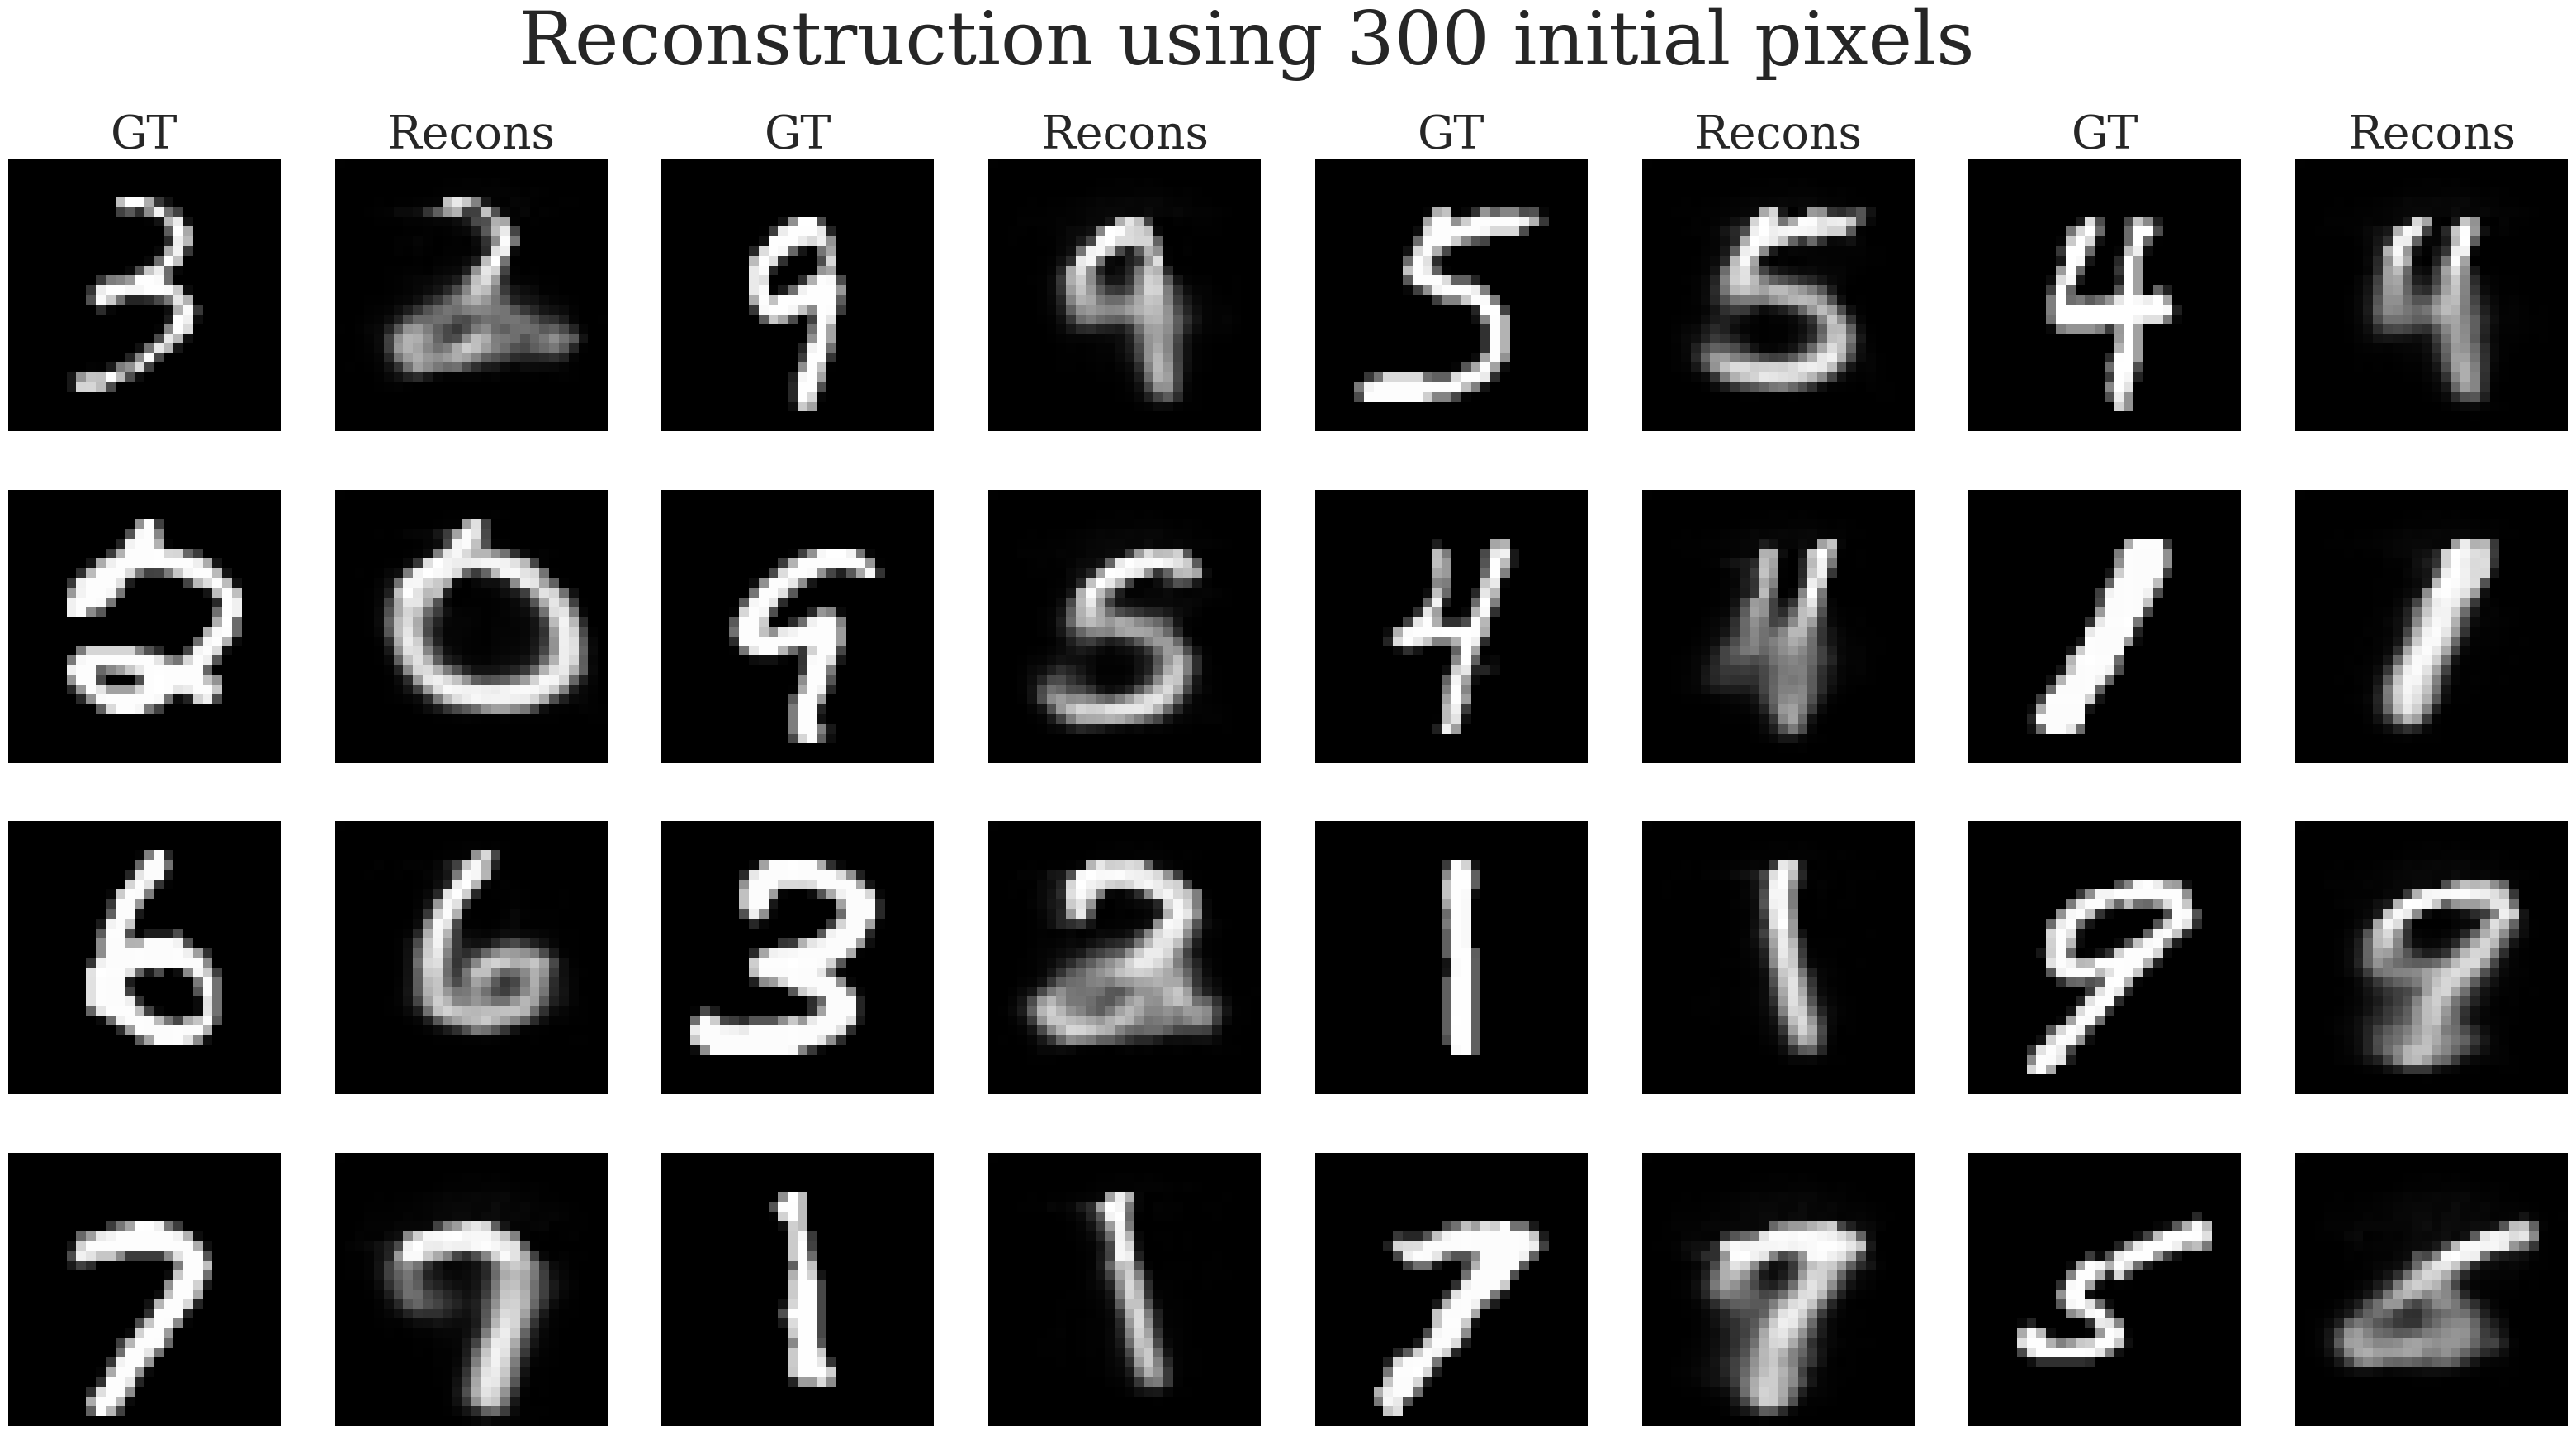

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    fig, axs = plt.subplots(4, 4*2, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
#%%

## Copy nohup.log to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    os.system(f"cp nohup.log {run_folder}")

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    fig, axs = plt.subplots(4, 4*2, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    fig, axs = plt.subplots(4, 4*2, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

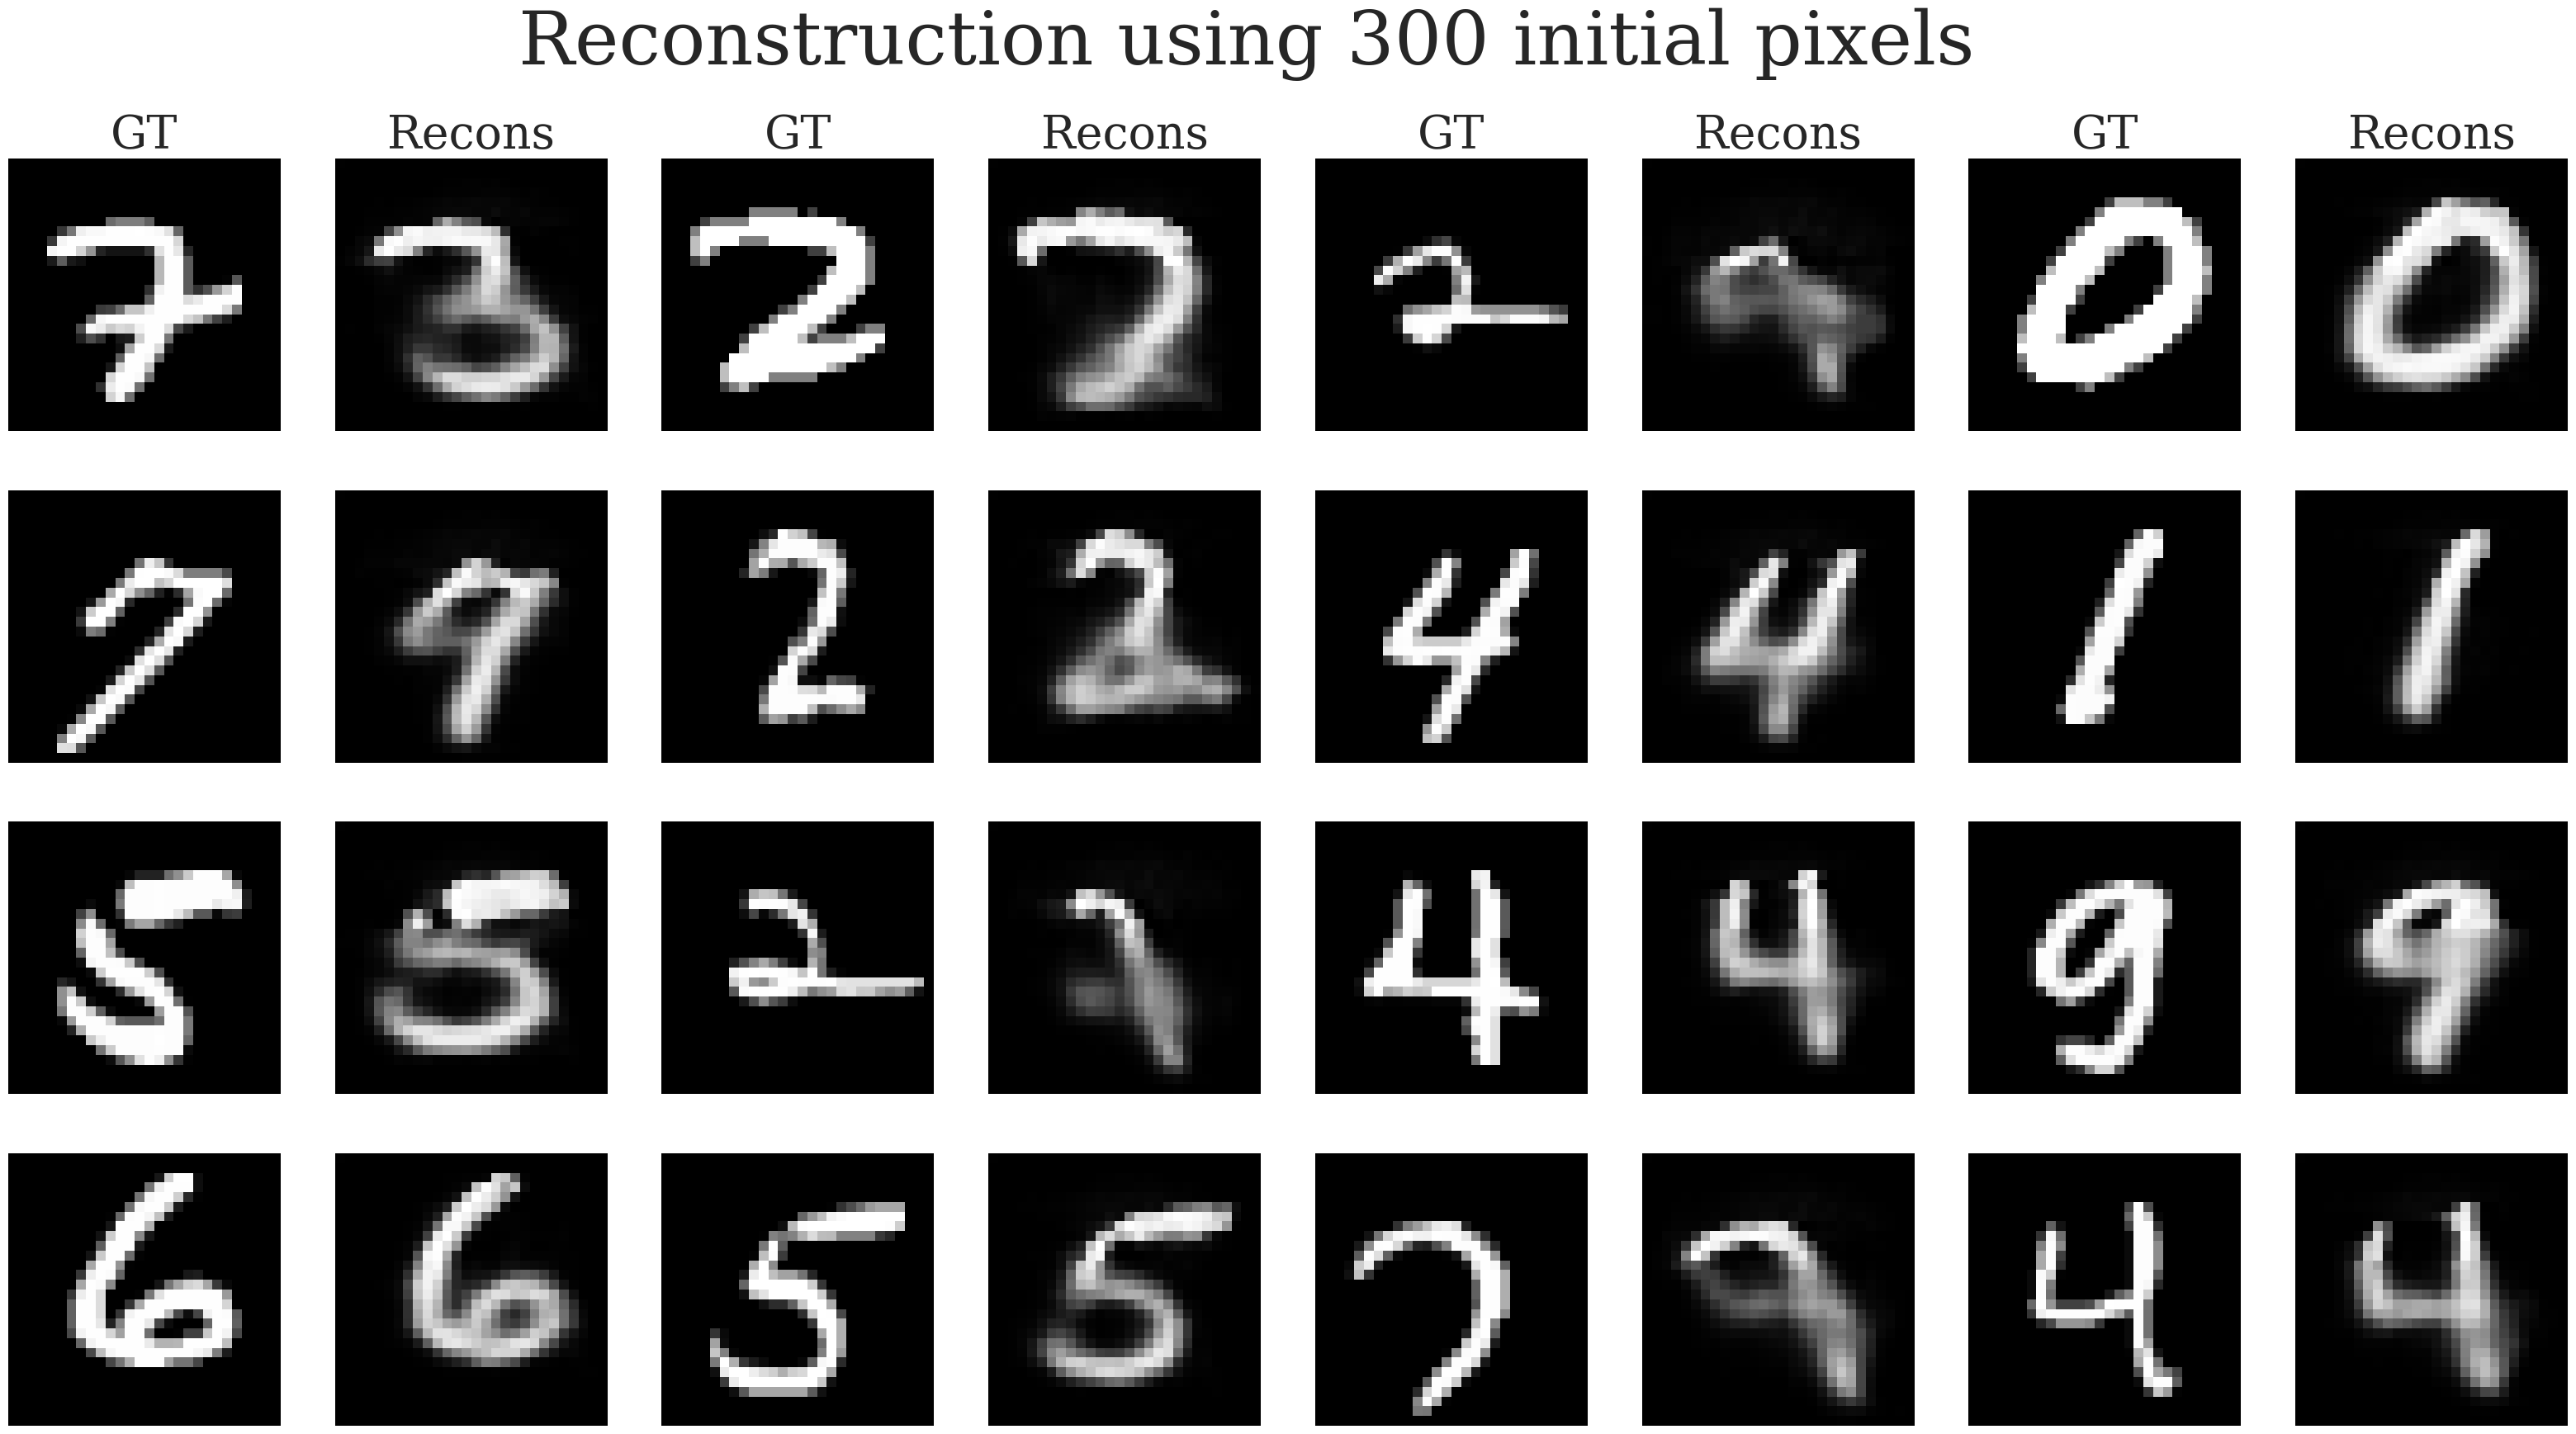

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    fig, axs = plt.subplots(4, 4*2, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

TypeError: cannot reshape array of shape (16, 784, 1) (size 12544) into shape (28, 28) (size 784)

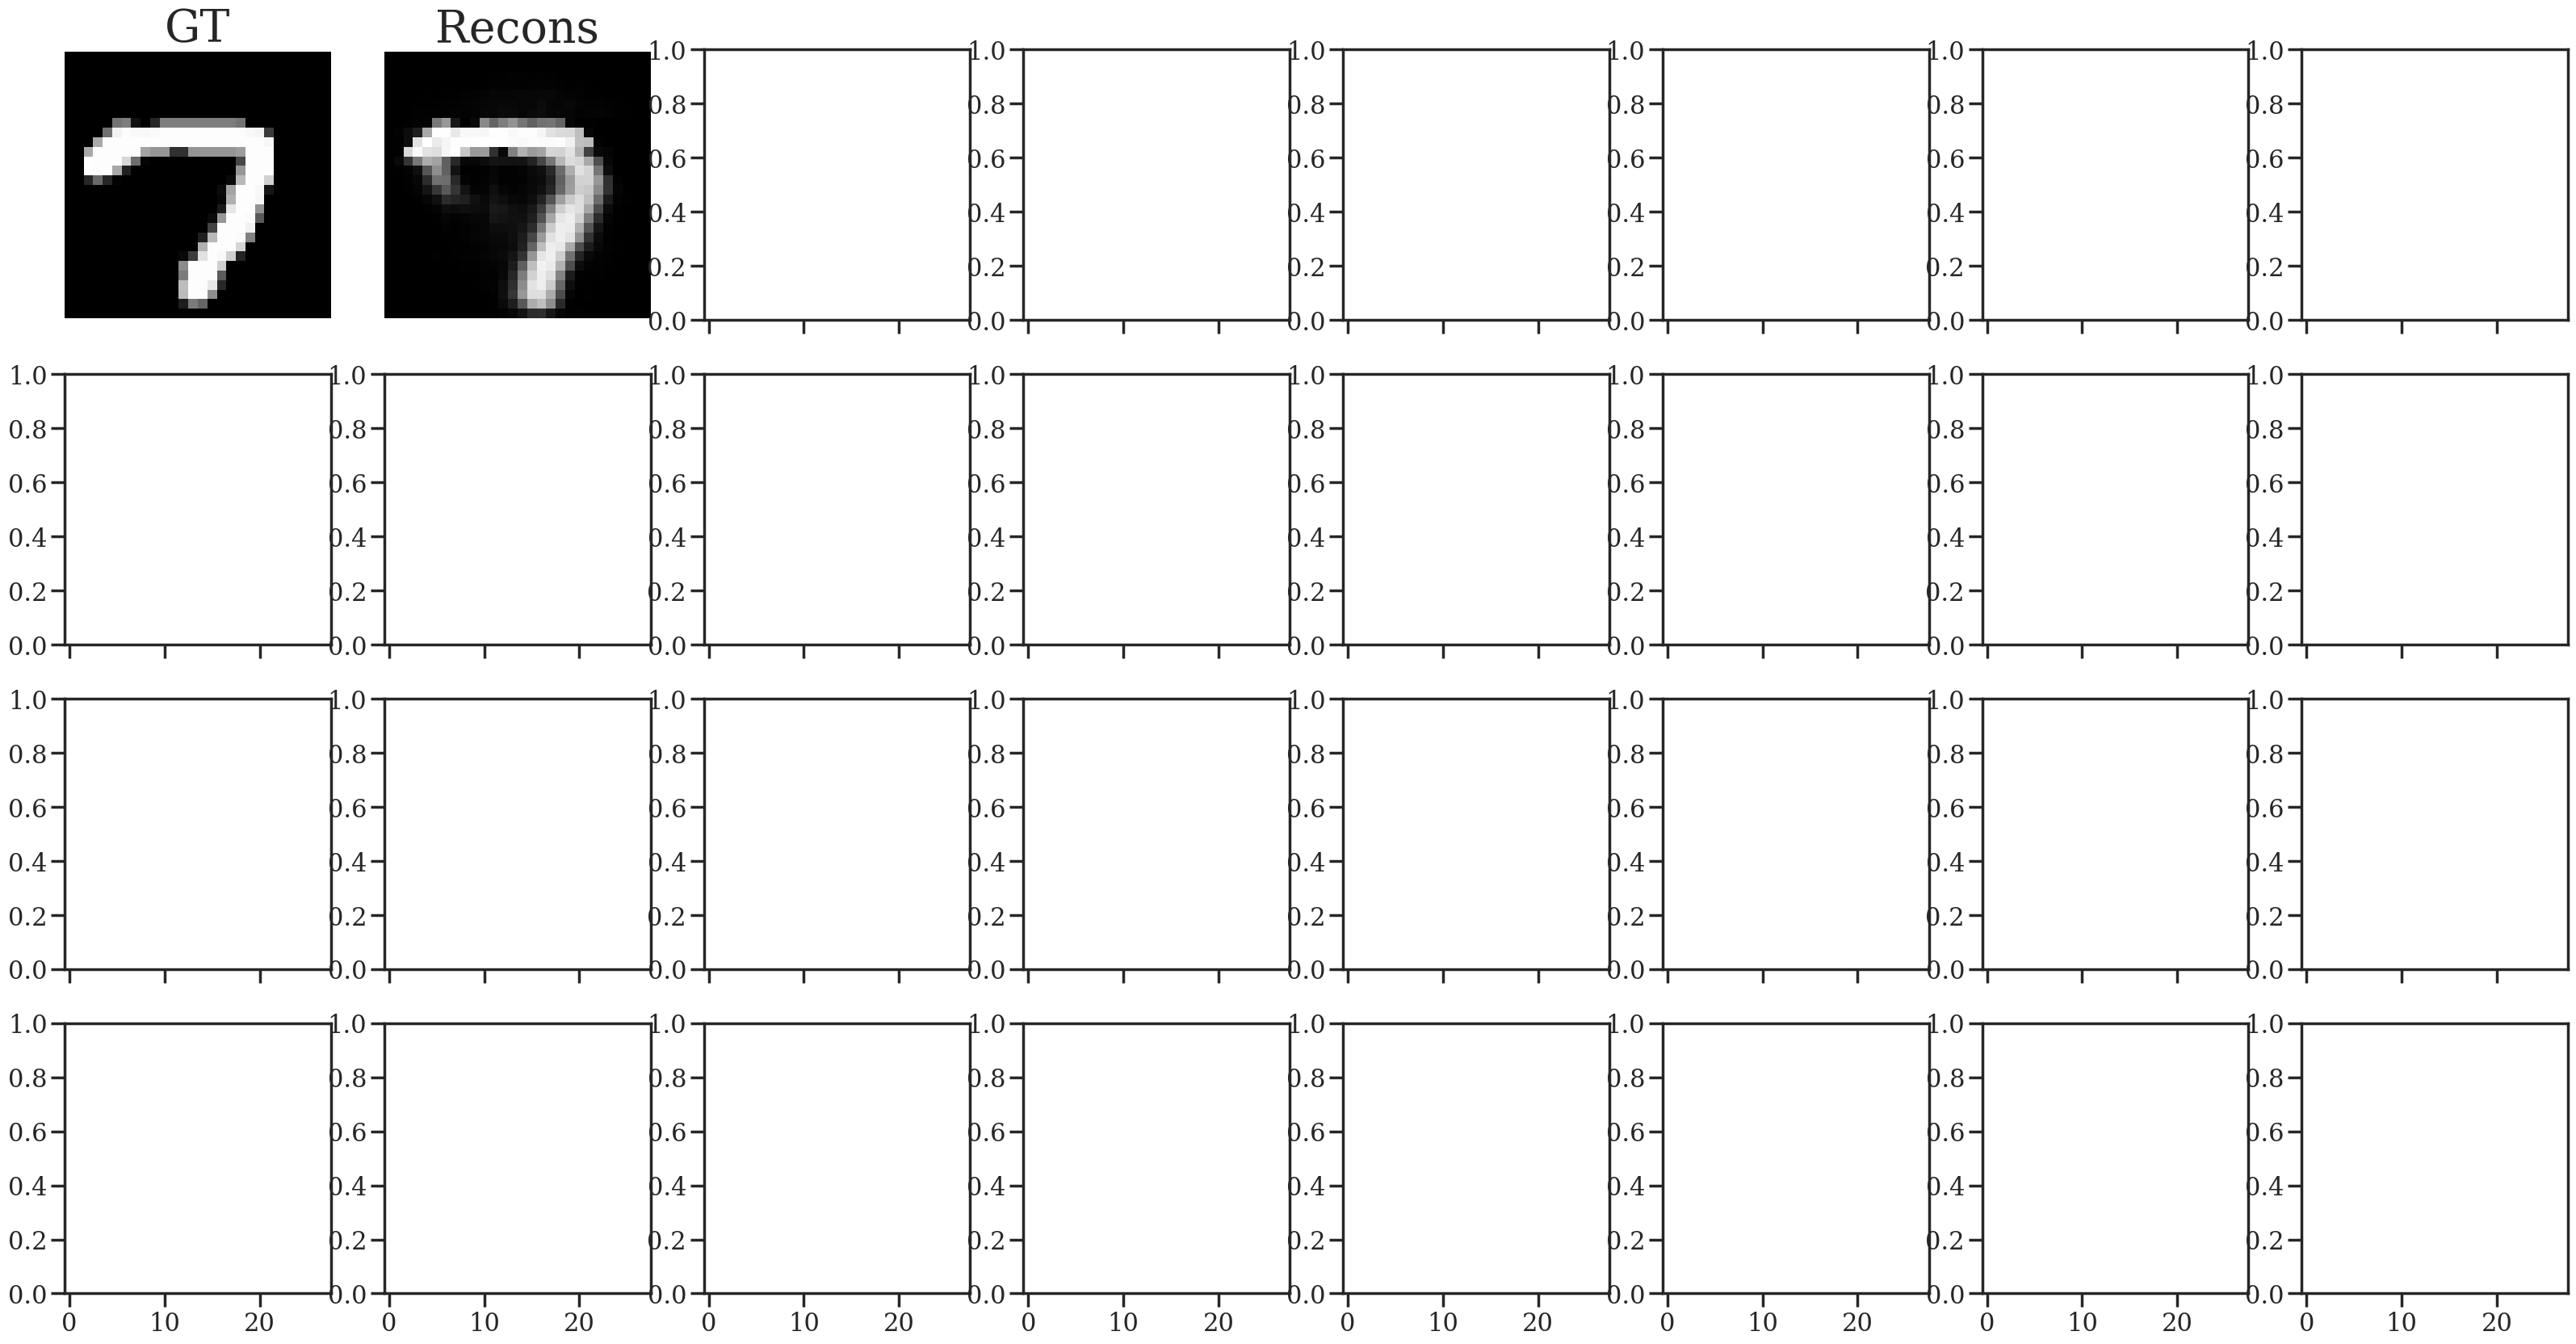

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                axs[i, 2*j+2].imshow(xs_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, 2*j+2].set_title("Diff", fontsize=40)
                axs[i, 2*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

NameError: name 'x_uncert' is not defined

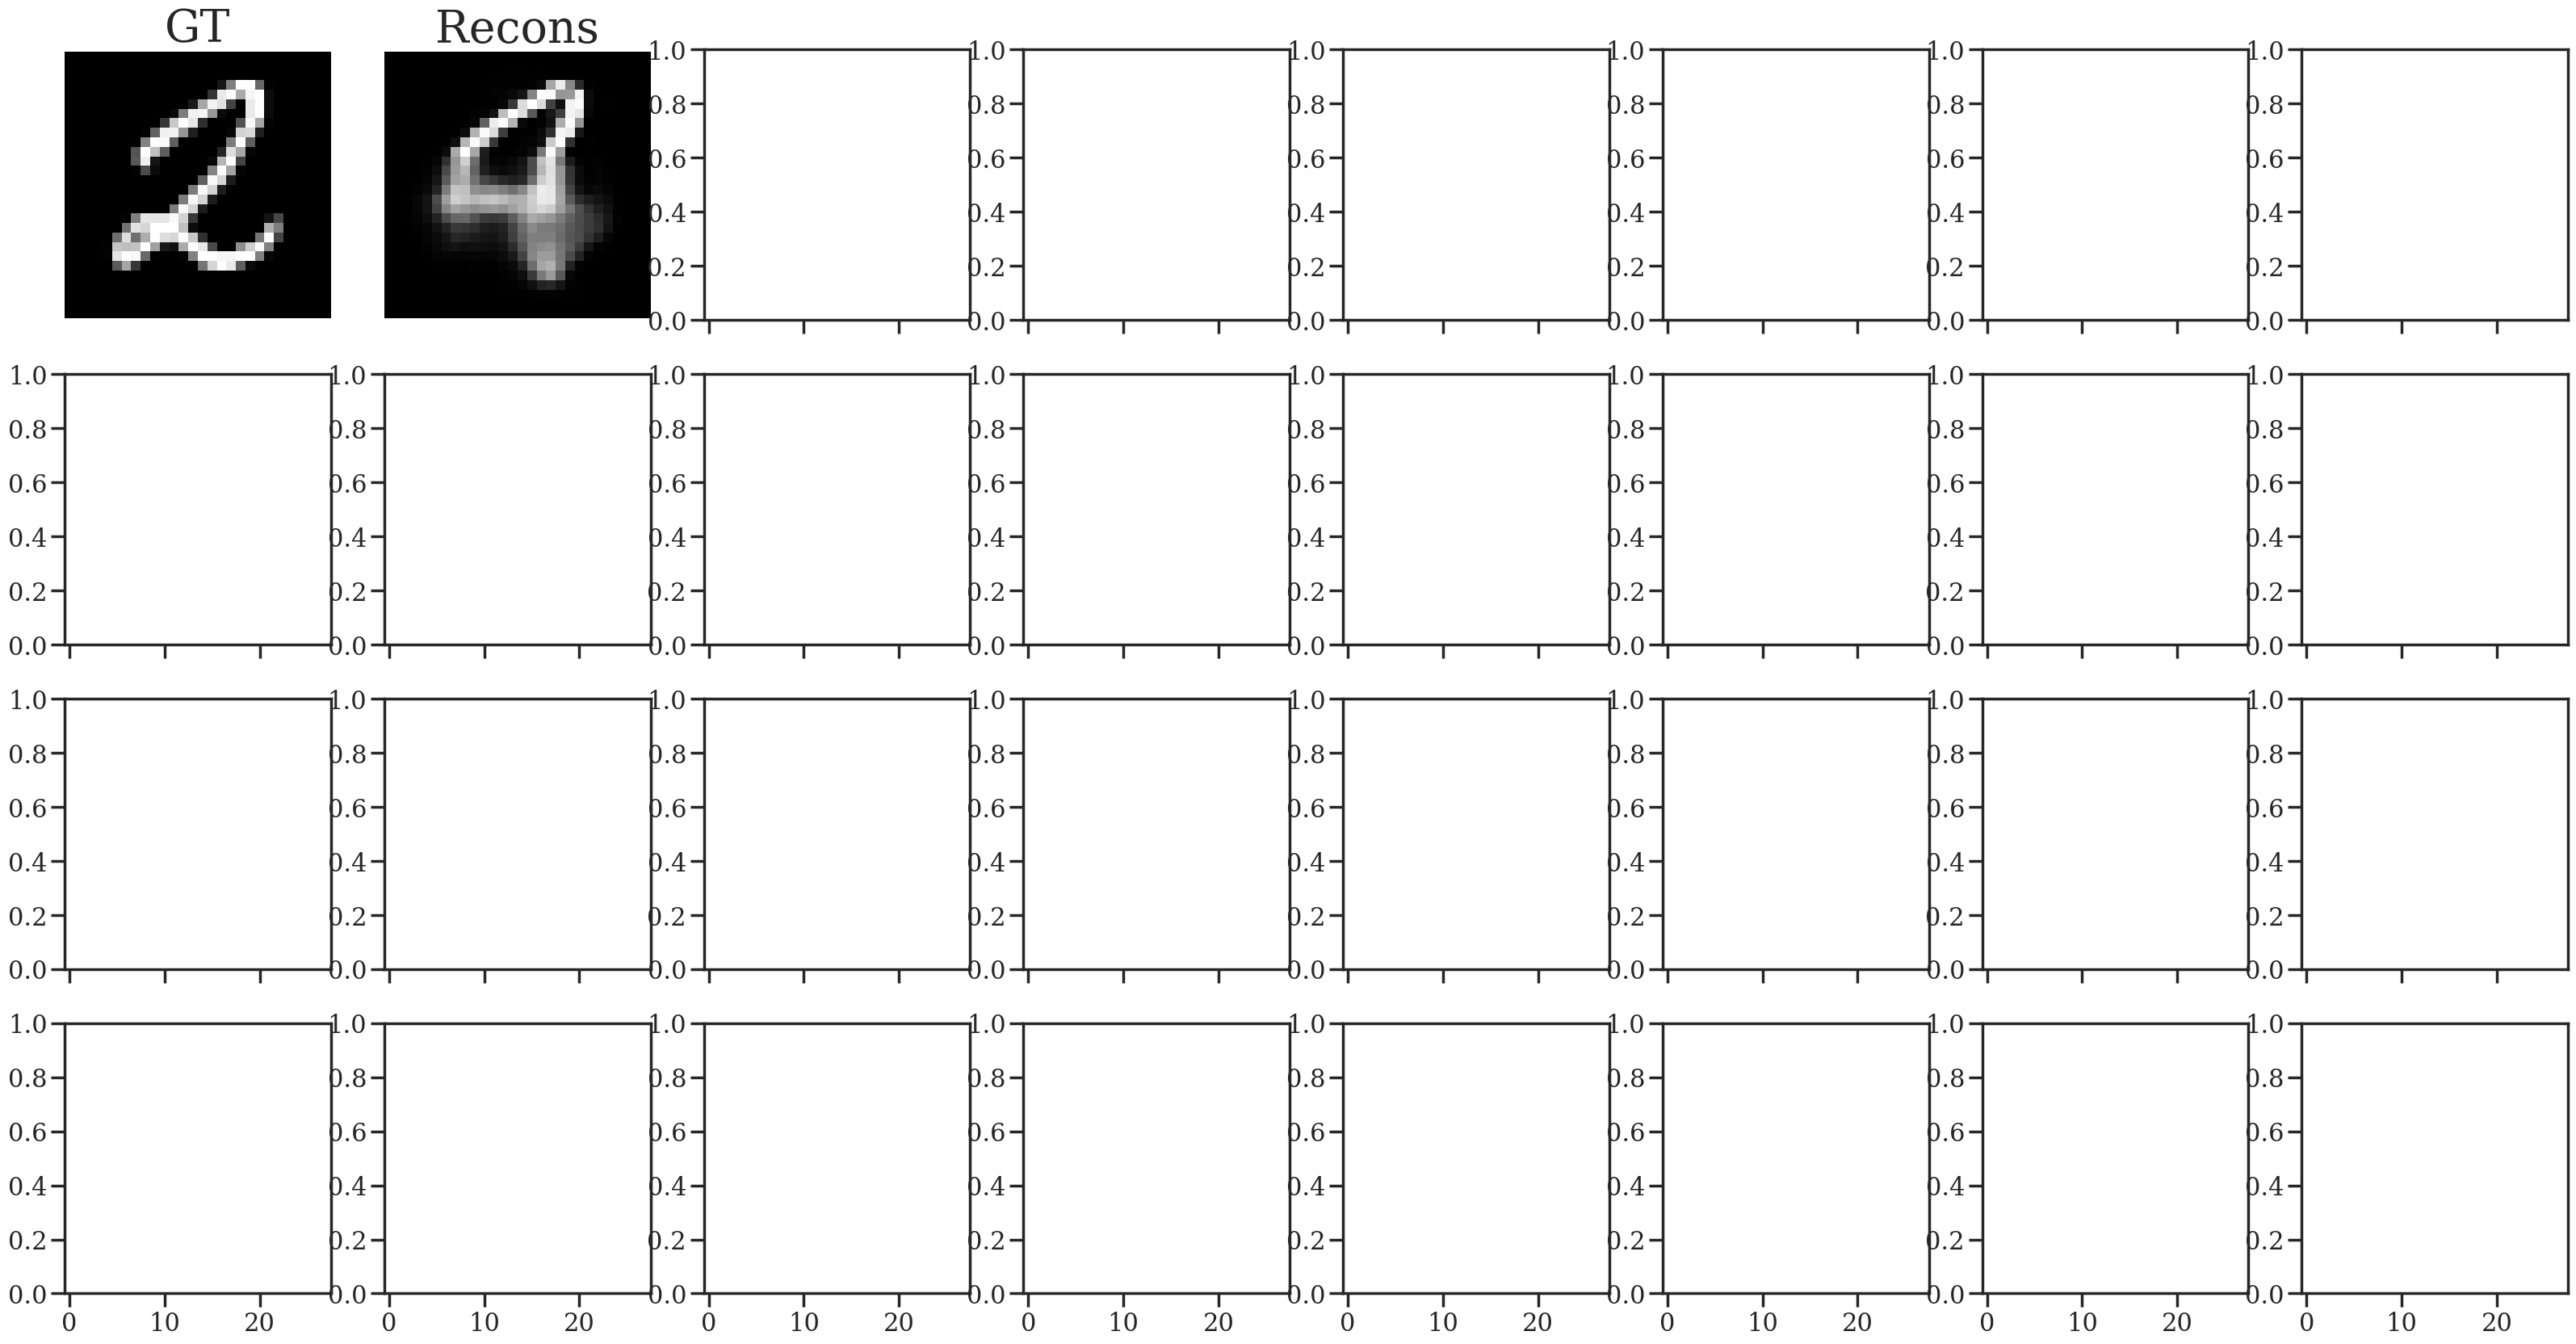

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert_ = xs_uncert[i*4+j]
                axs[i, 2*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, 2*j+2].set_title("Diff", fontsize=40)
                axs[i, 2*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

IndexError: index 8 is out of bounds for axis 1 with size 8

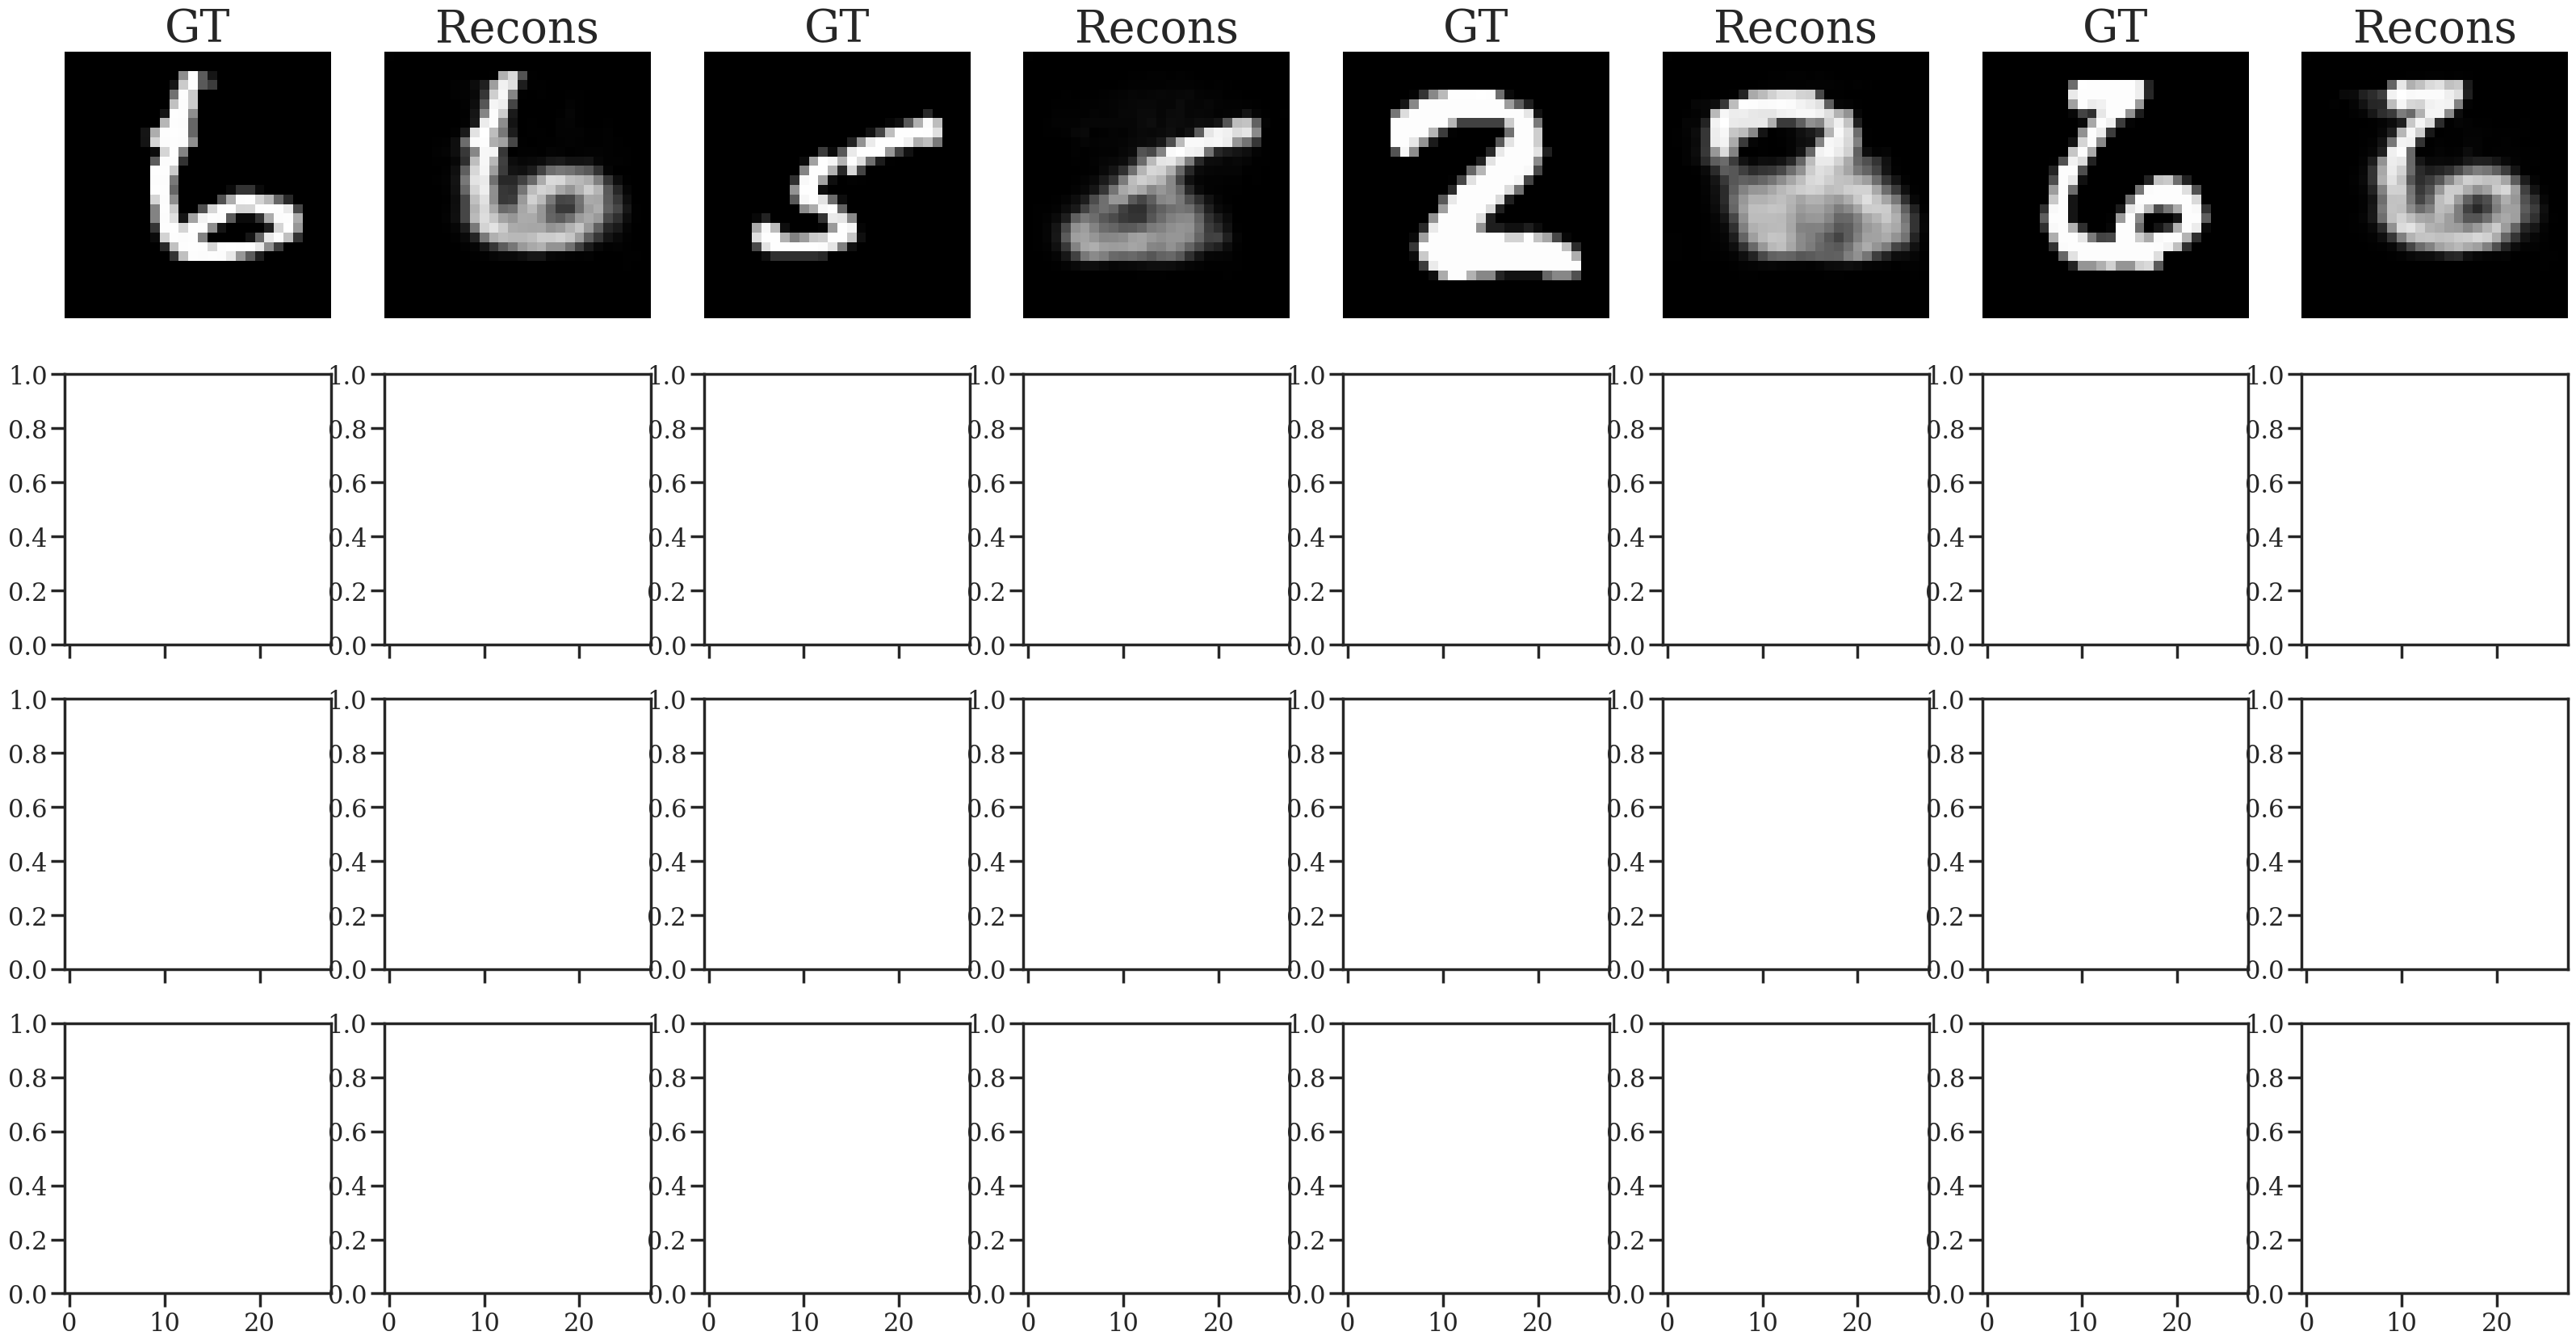

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, 2*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j].set_title("GT", fontsize=40)
            axs[i, 2*j].axis('off')

            if run_mnist:
                axs[i, 2*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, 2*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, 2*j+1].set_title("Recons", fontsize=40)
            axs[i, 2*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, 2*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, 2*j+2].set_title("Diff", fontsize=40)
                axs[i, 2*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

IndexError: index 8 is out of bounds for axis 1 with size 8

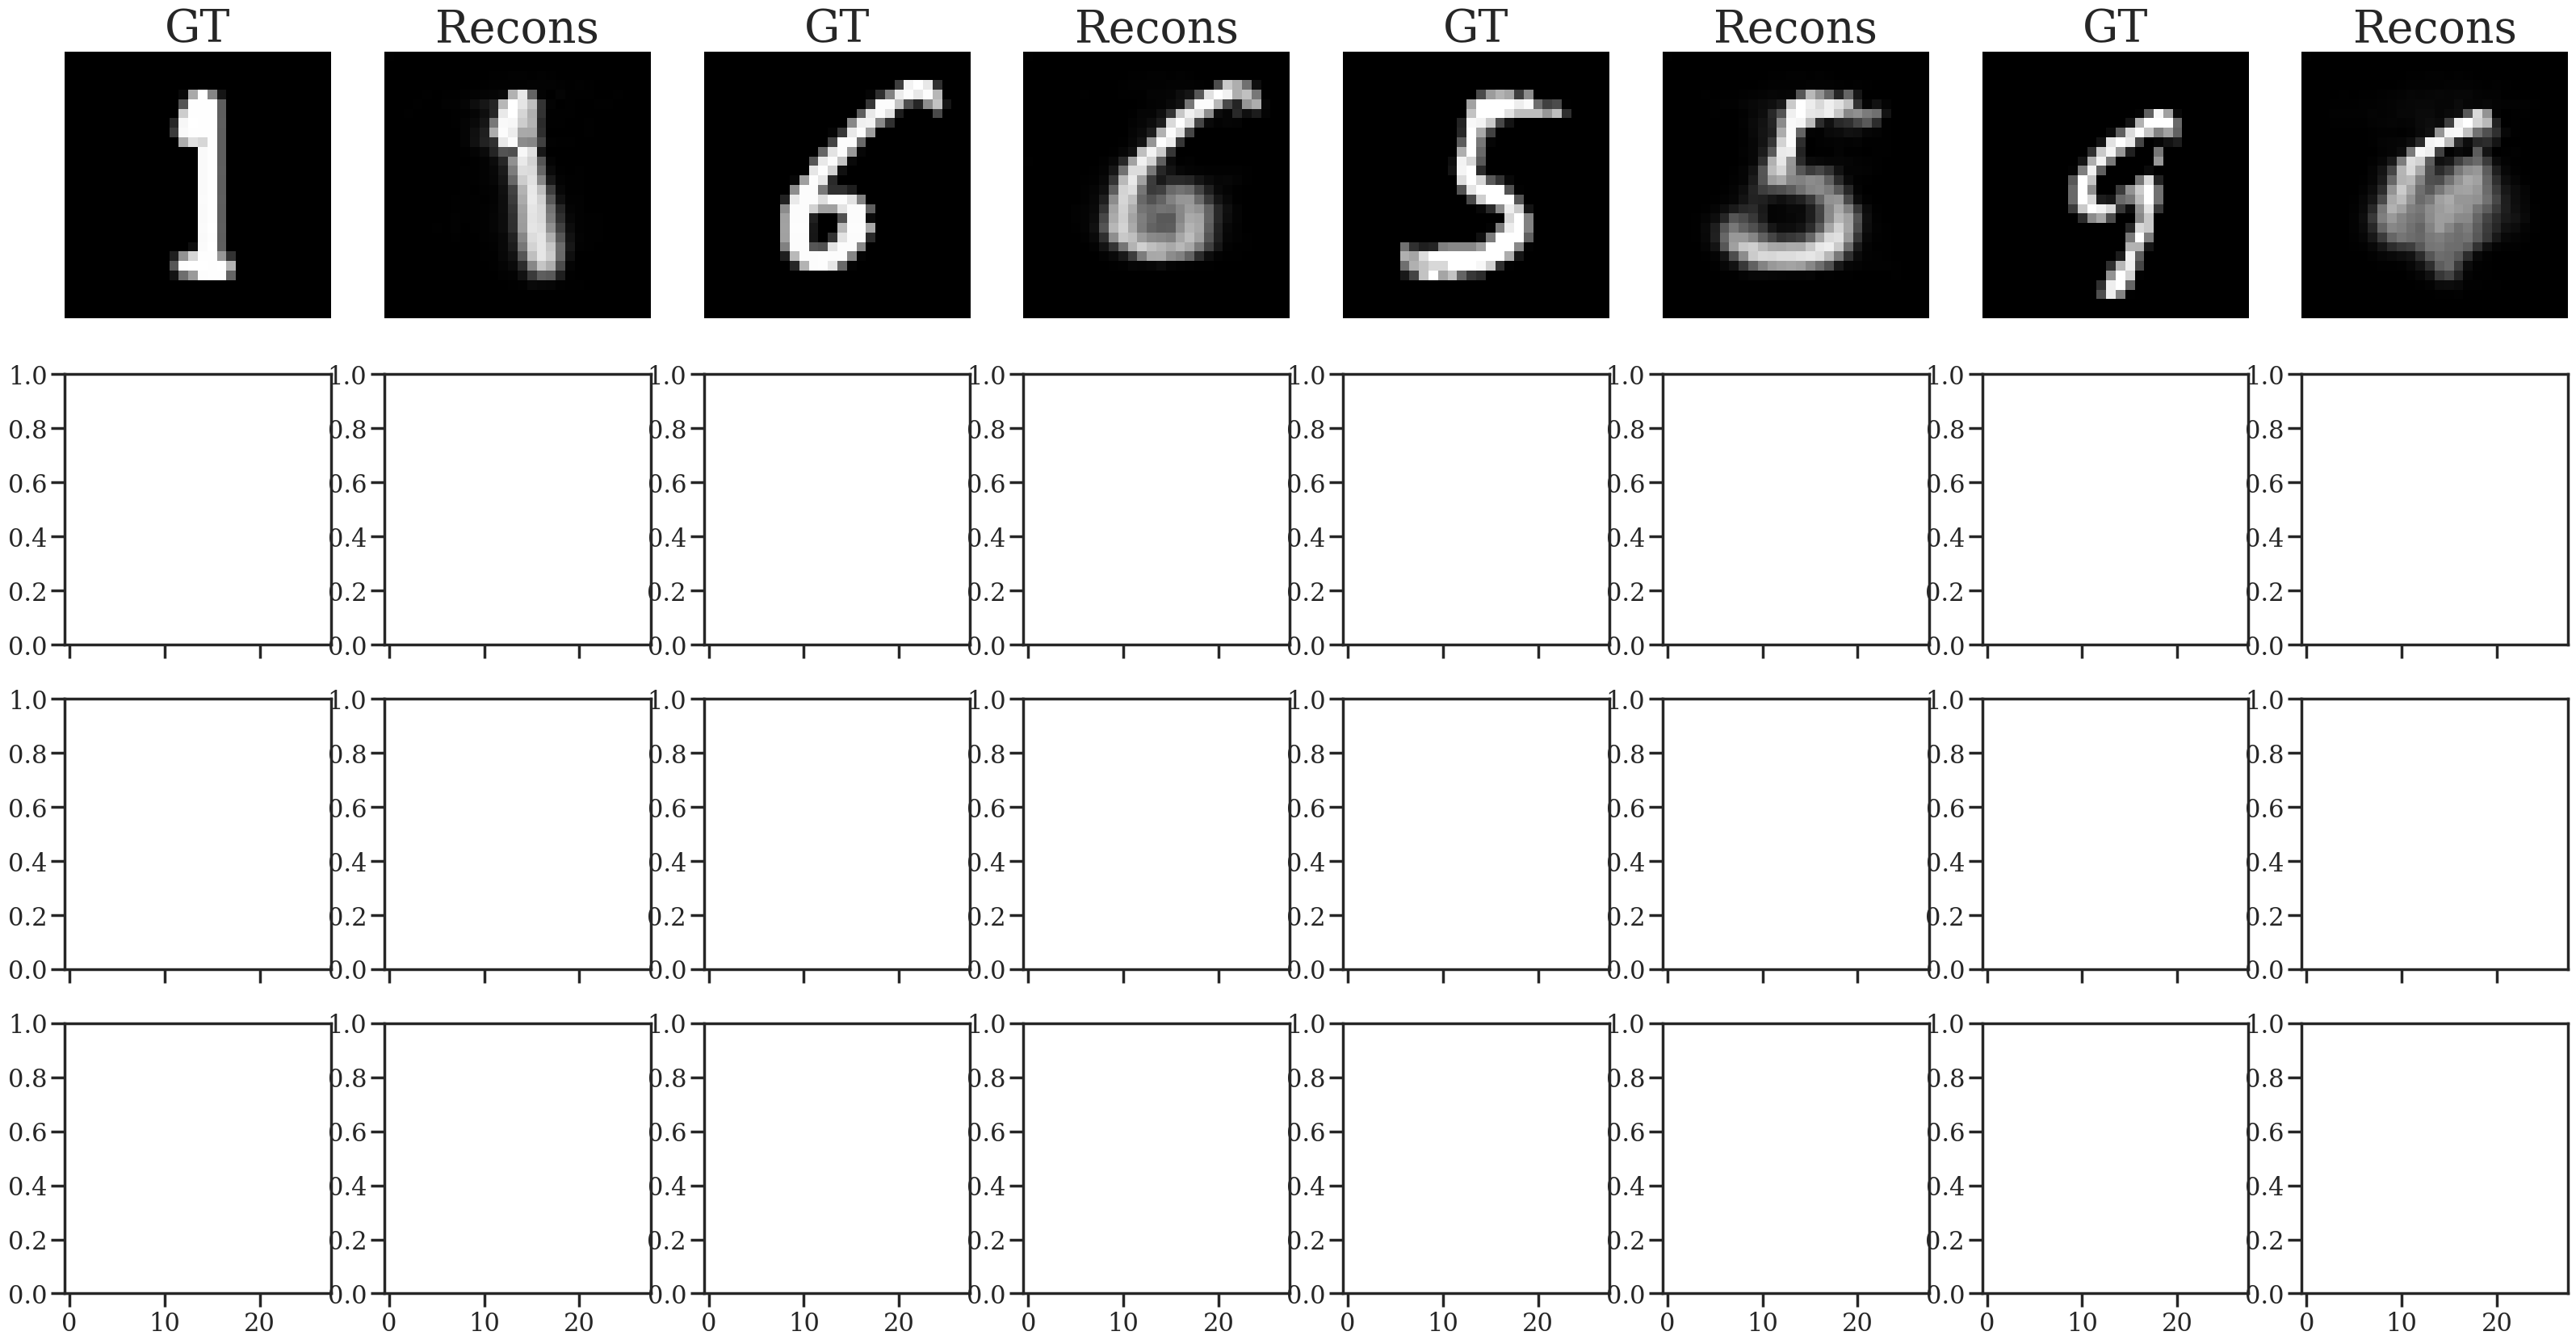

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Diff", fontsize=40)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

IndexError: index 8 is out of bounds for axis 1 with size 8

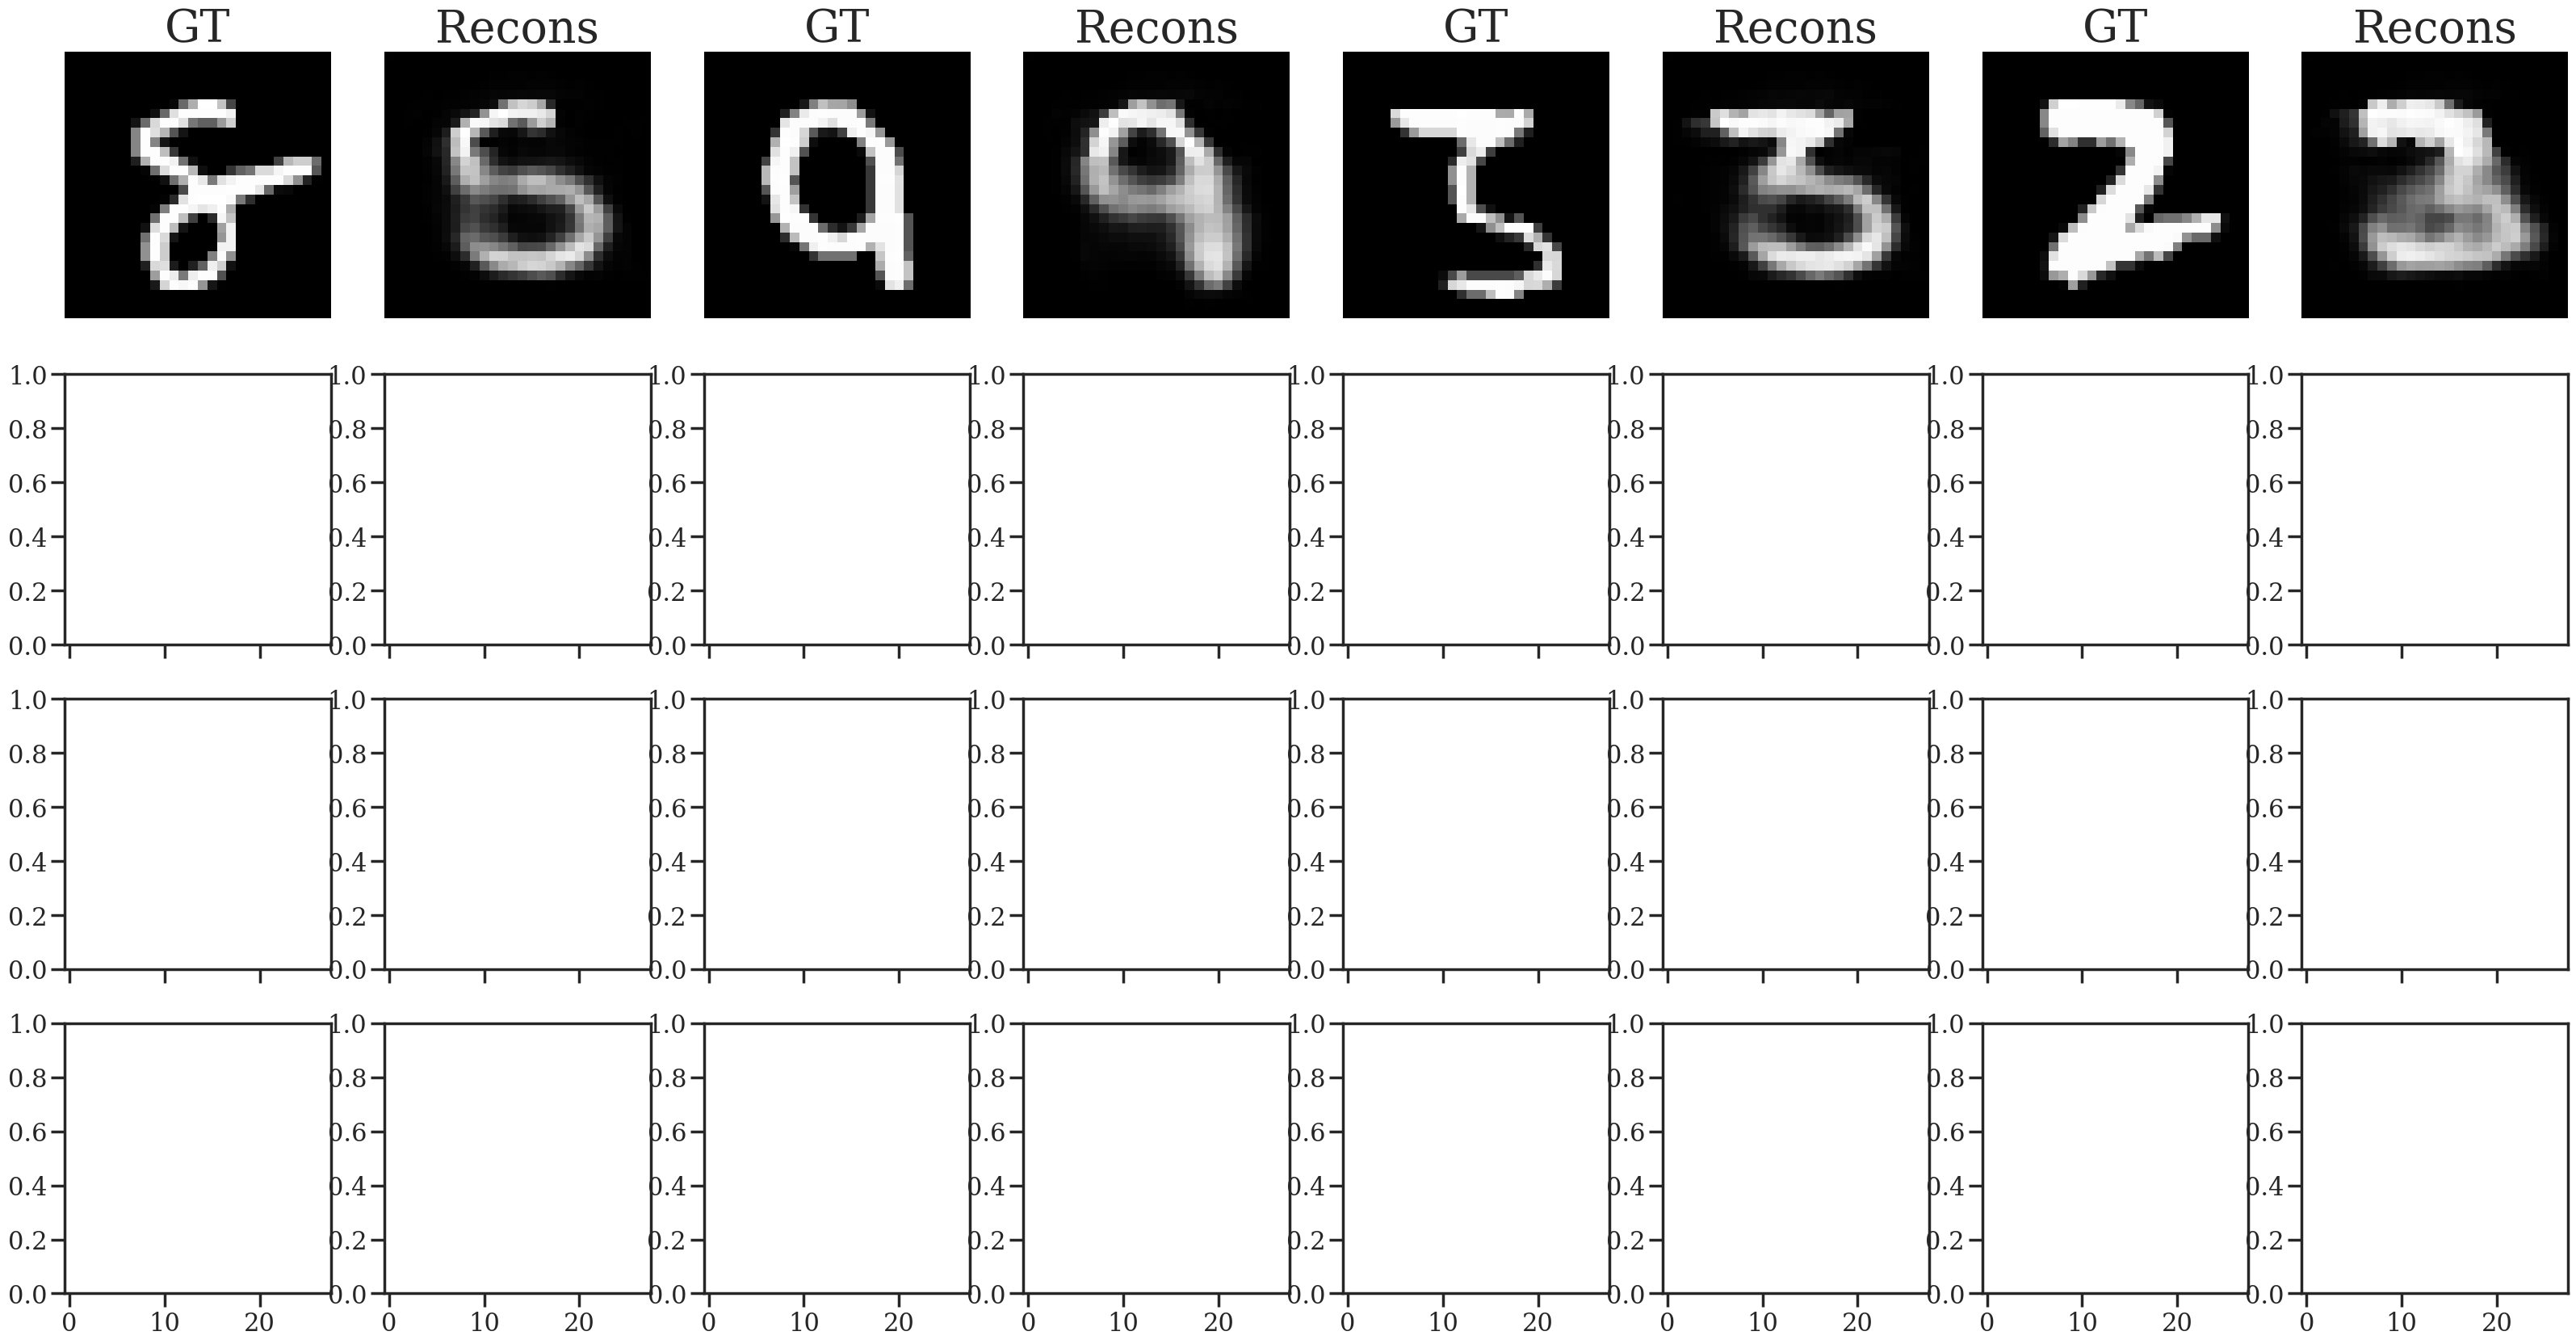

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Diff", fontsize=40)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

IndexError: index 8 is out of bounds for axis 1 with size 8

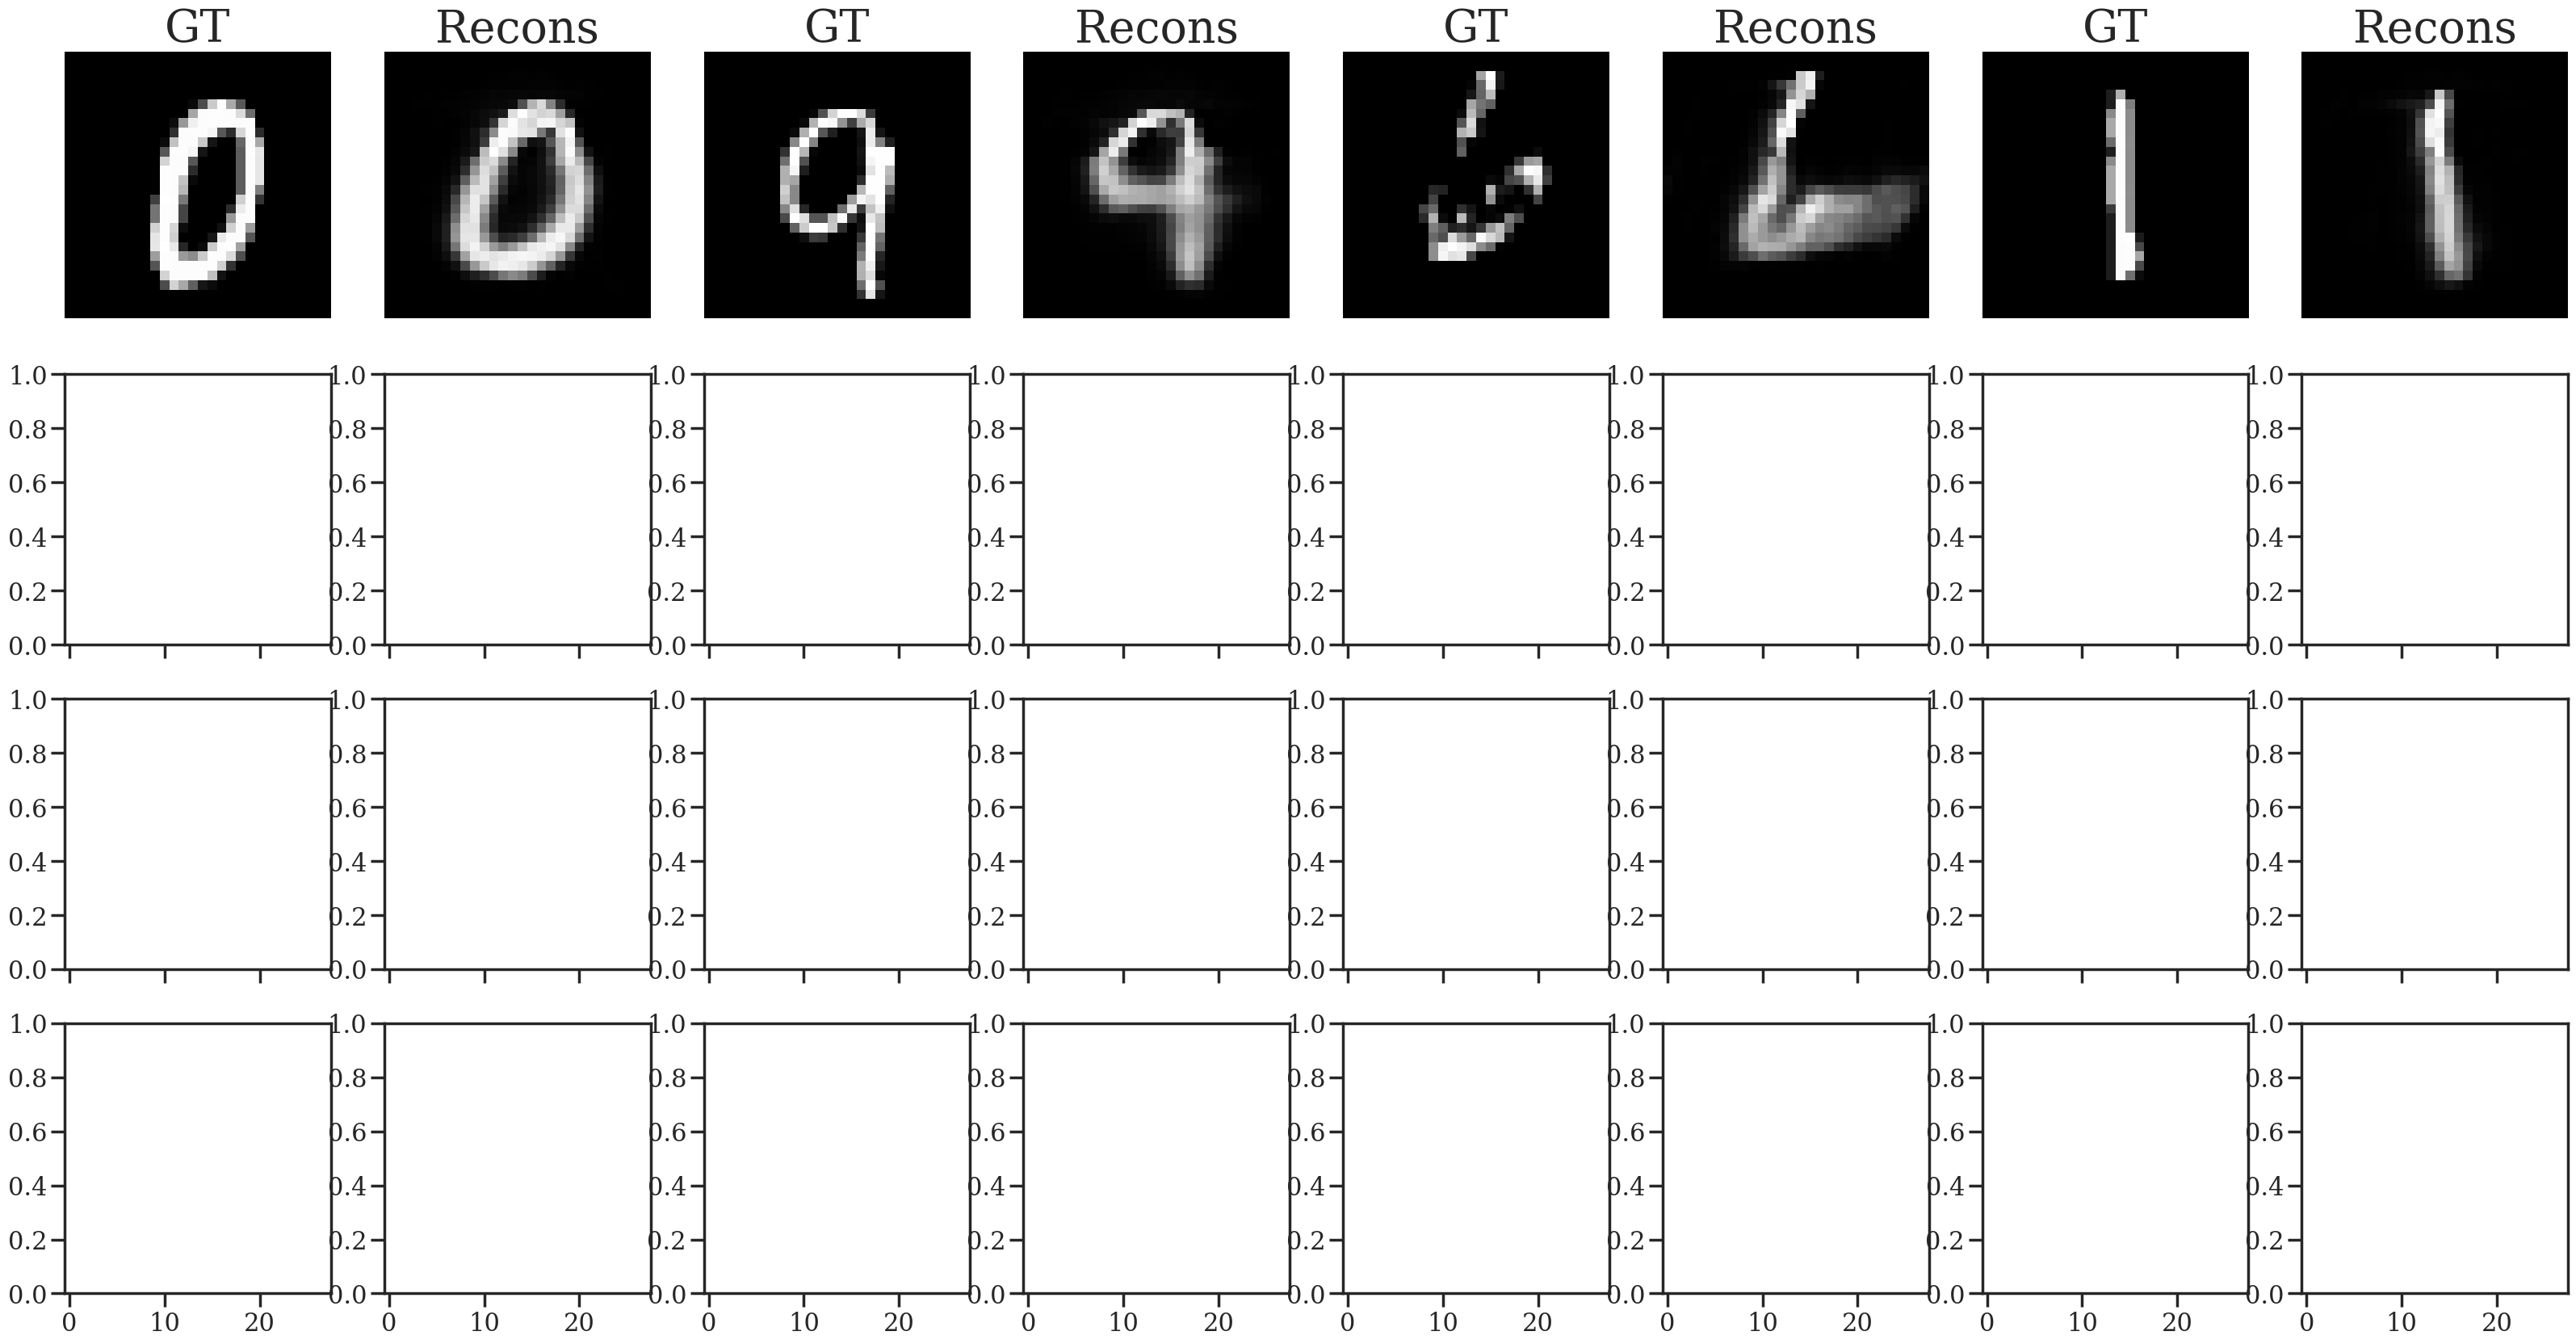

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Diff", fontsize=40)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

nb cold j and i: 2 0 0
nb cold j and i: 2 1 0
nb cold j and i: 2 2 0
nb cold j and i: 2 3 0


IndexError: index 8 is out of bounds for axis 1 with size 8

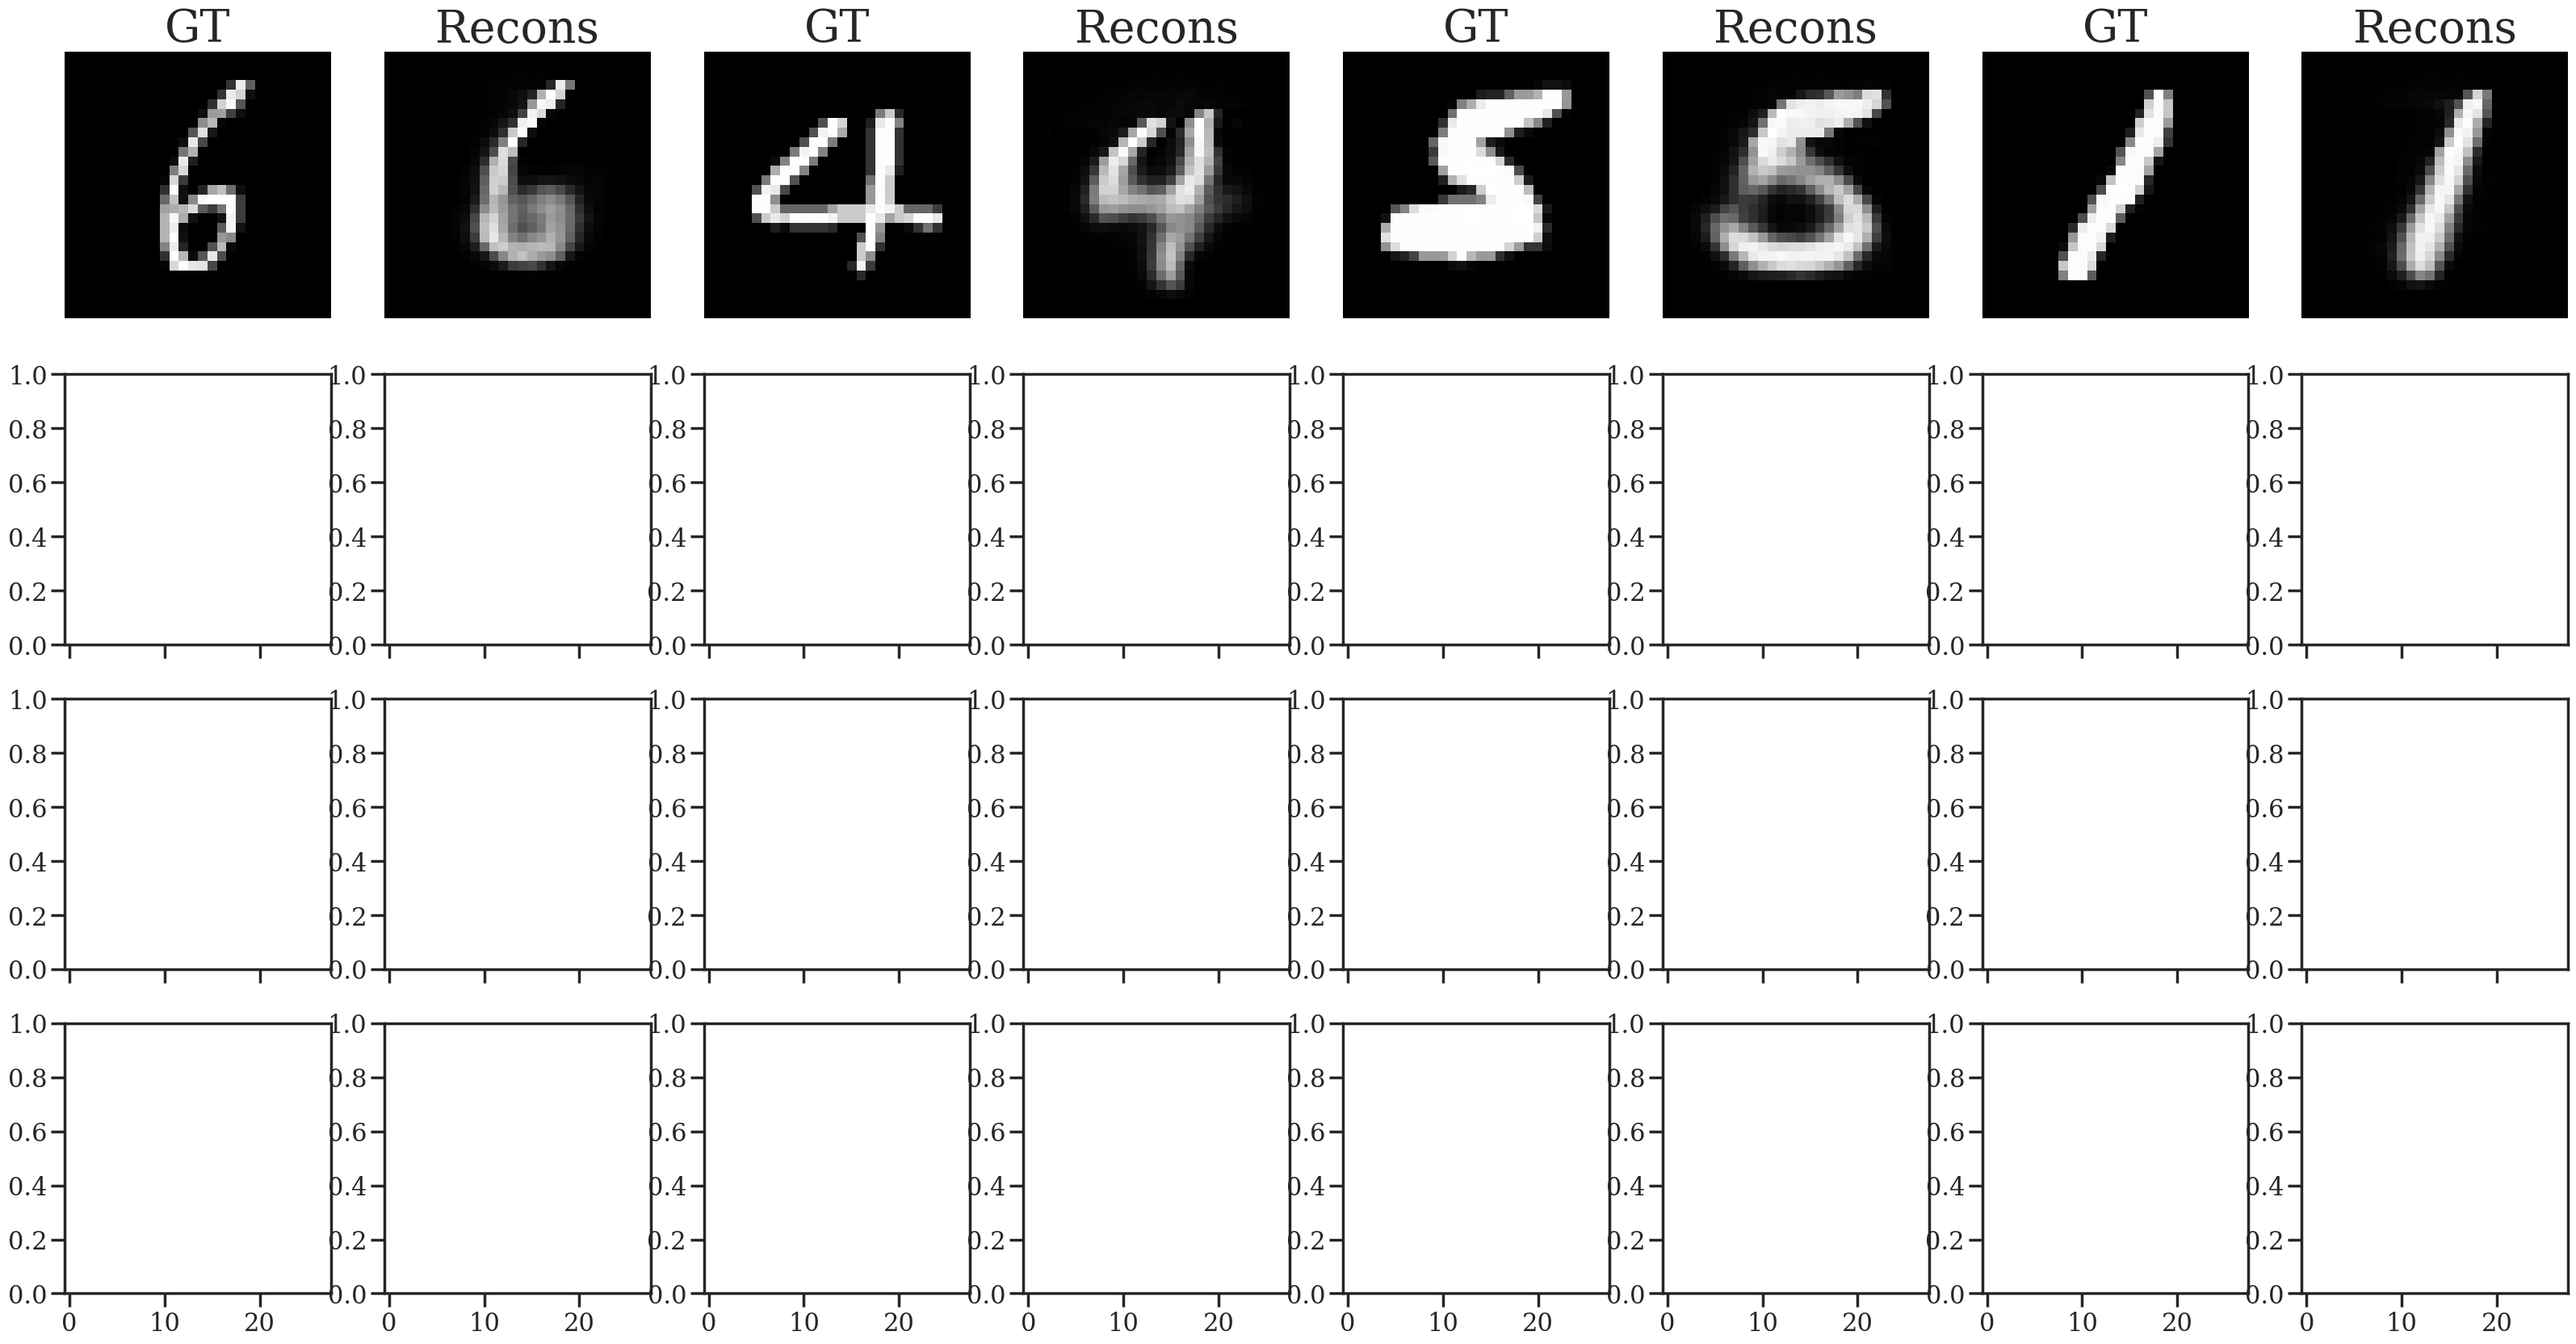

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 2 if not use_mse_loss else 3
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                print("nb cold j and i:", nb_cols, j, i)
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Diff", fontsize=40)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

nb cold j and i: 3 0 0
nb cold j and i: 3 1 0
nb cold j and i: 3 2 0
nb cold j and i: 3 3 0
nb cold j and i: 3 0 1
nb cold j and i: 3 1 1
nb cold j and i: 3 2 1
nb cold j and i: 3 3 1
nb cold j and i: 3 0 2
nb cold j and i: 3 1 2
nb cold j and i: 3 2 2
nb cold j and i: 3 3 2
nb cold j and i: 3 0 3
nb cold j and i: 3 1 3
nb cold j and i: 3 2 3
nb cold j and i: 3 3 3


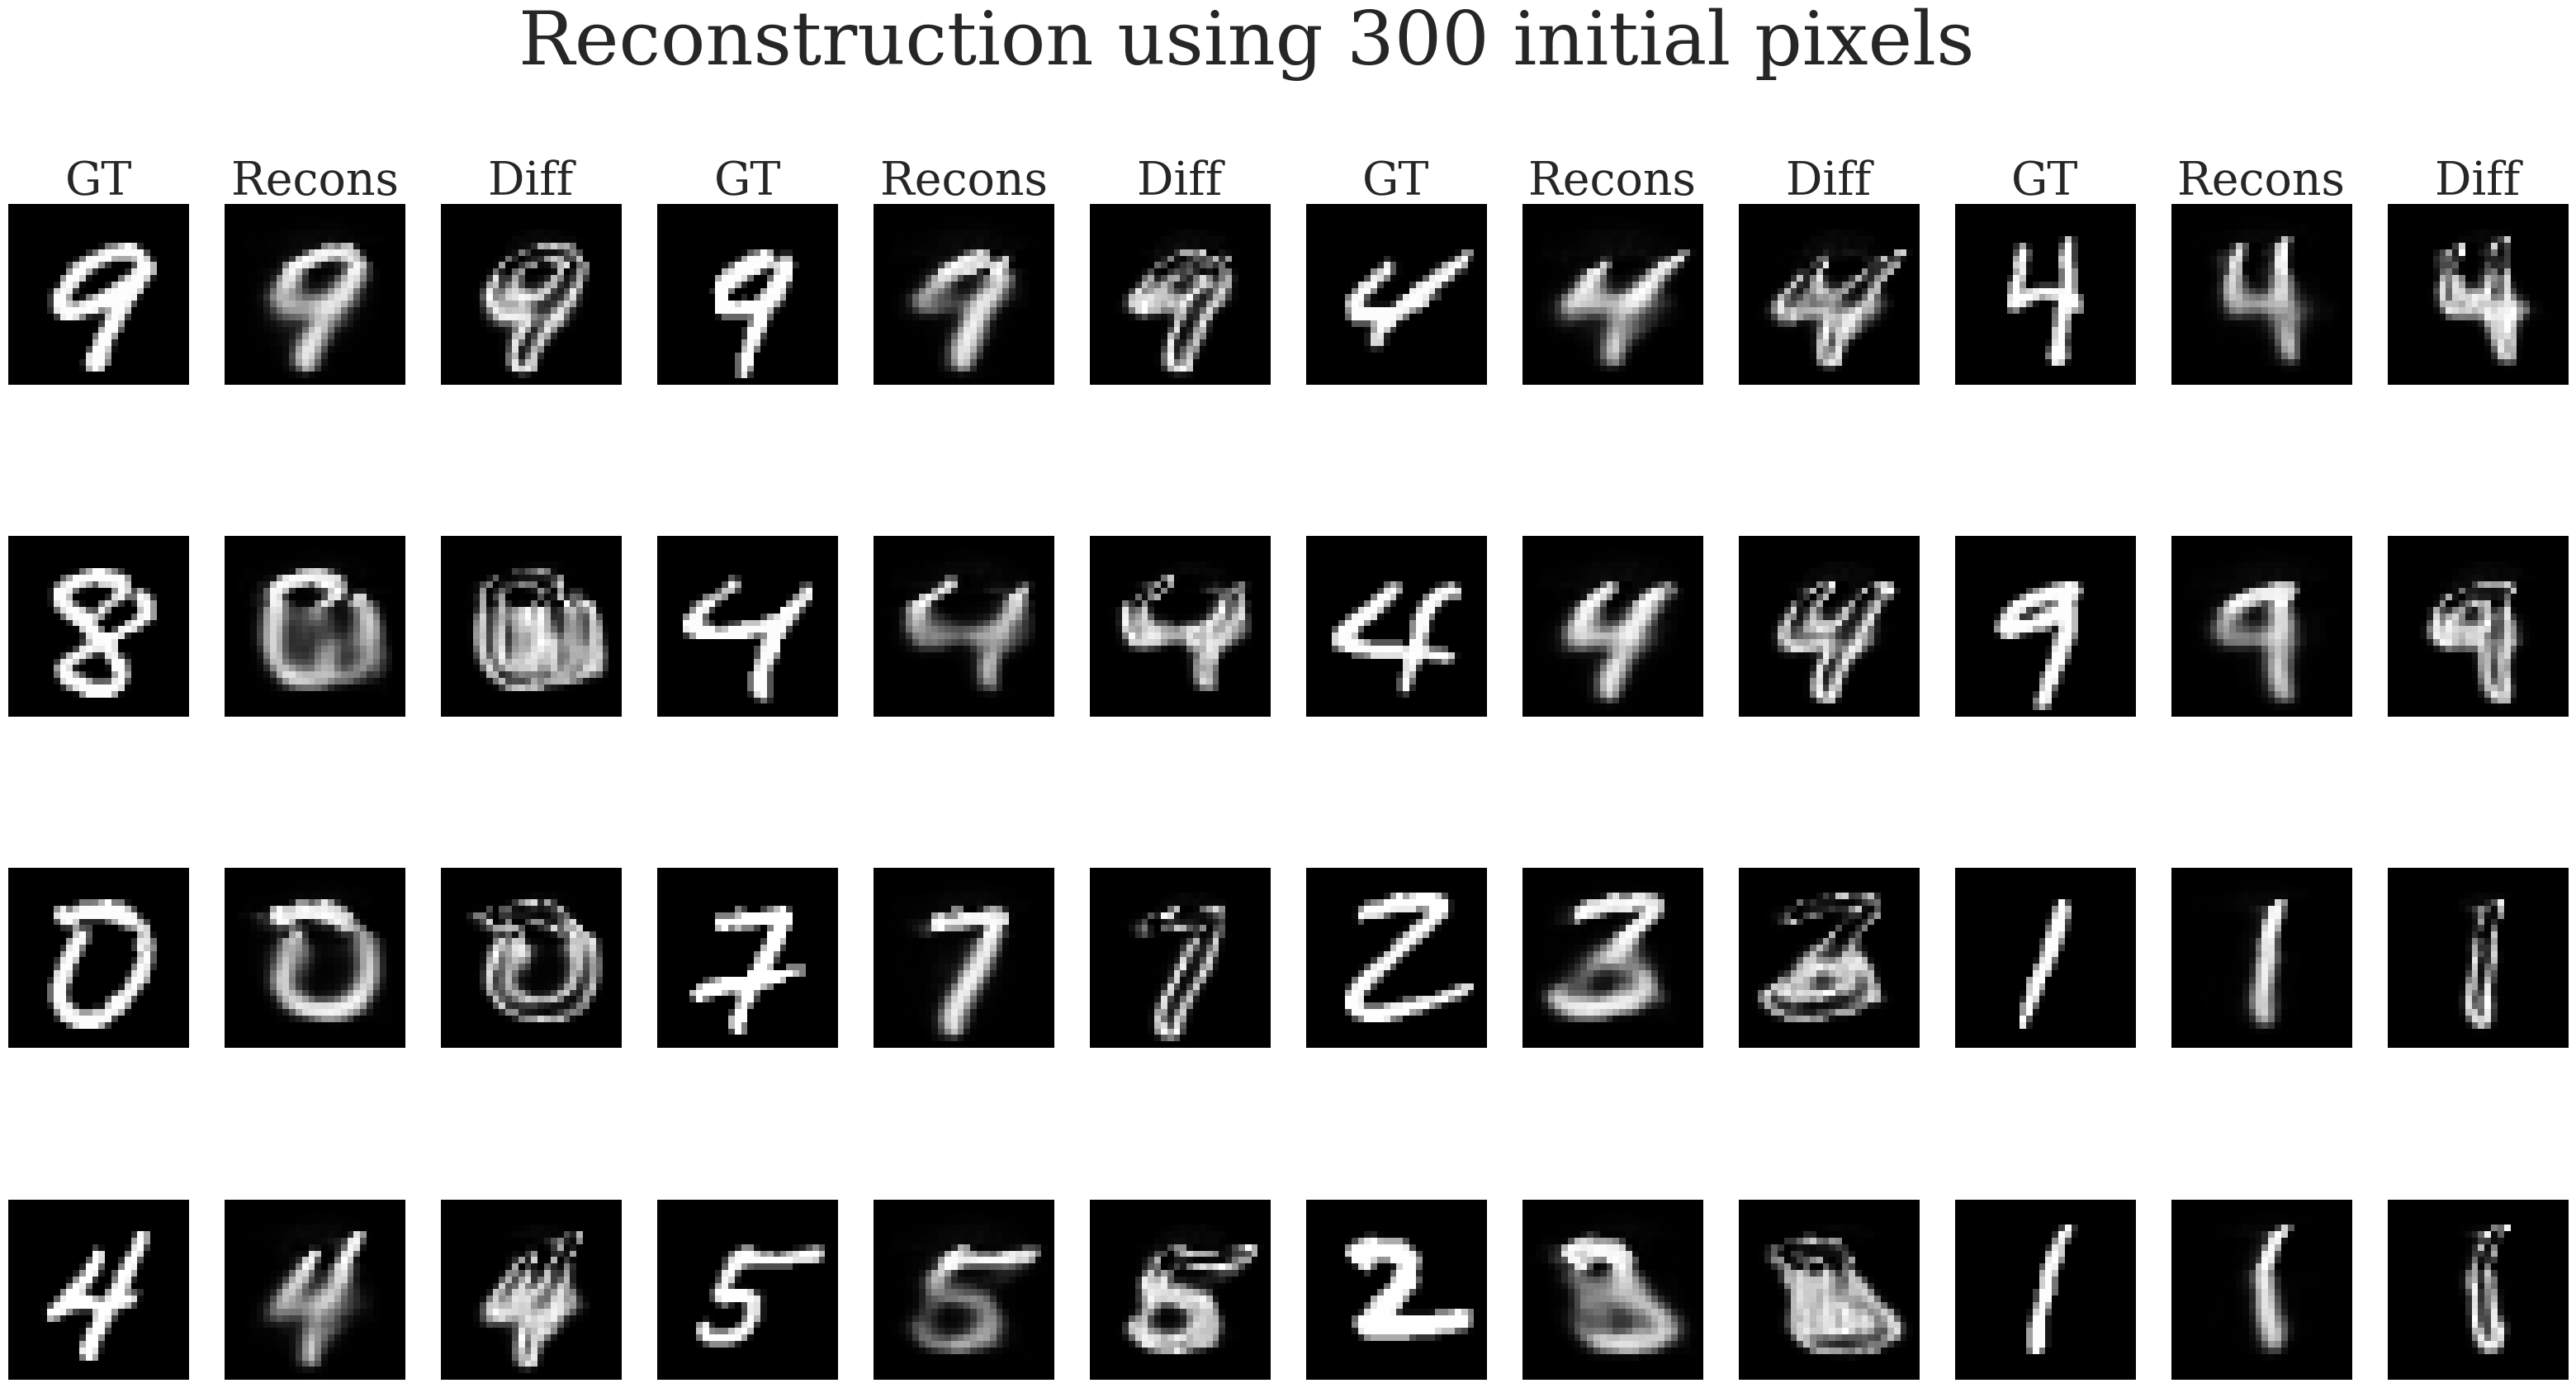

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(20*2, 20), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                print("nb cold j and i:", nb_cols, j, i)
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Diff", fontsize=40)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

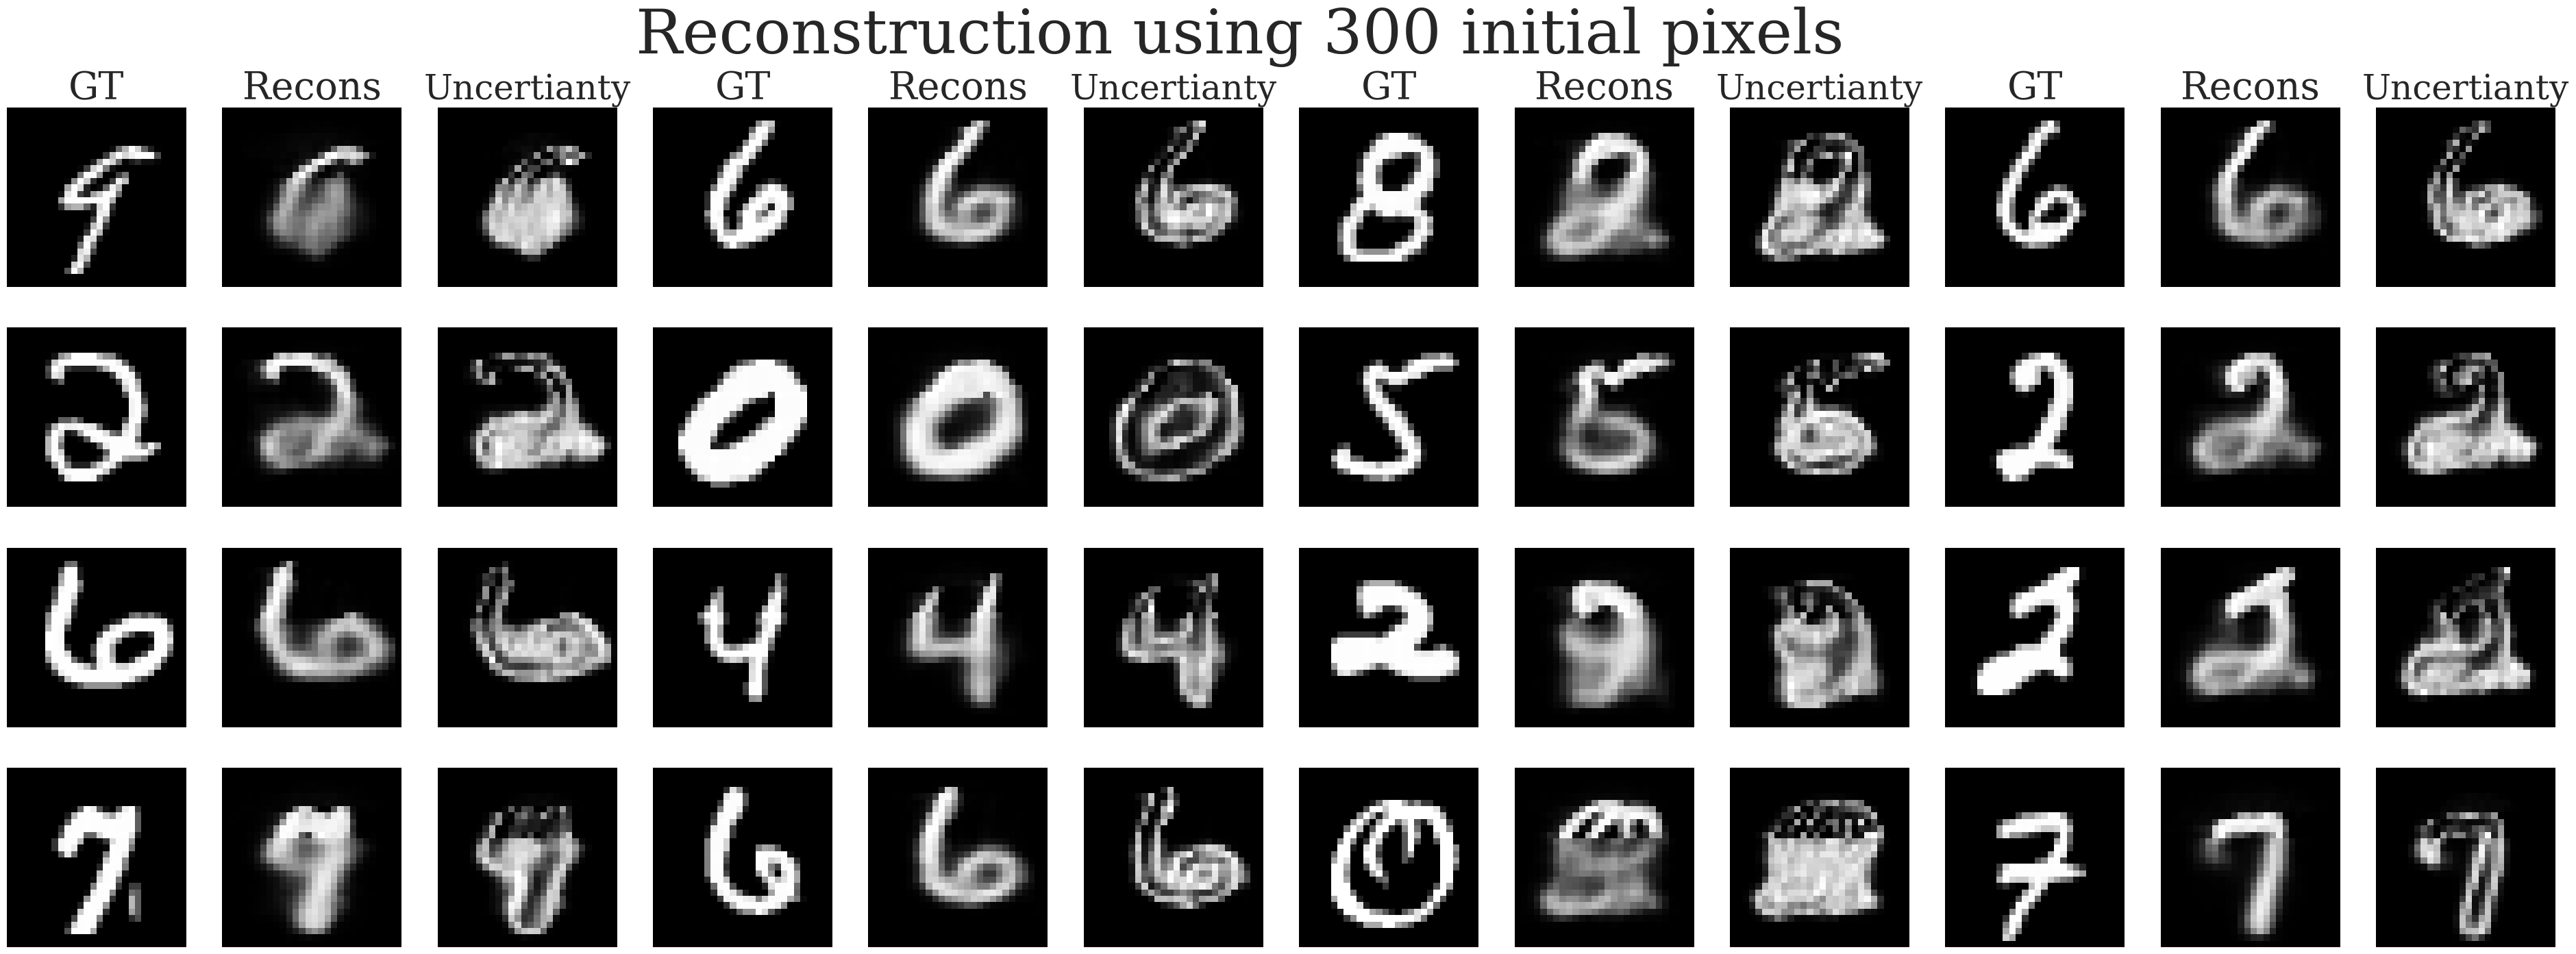

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertianty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

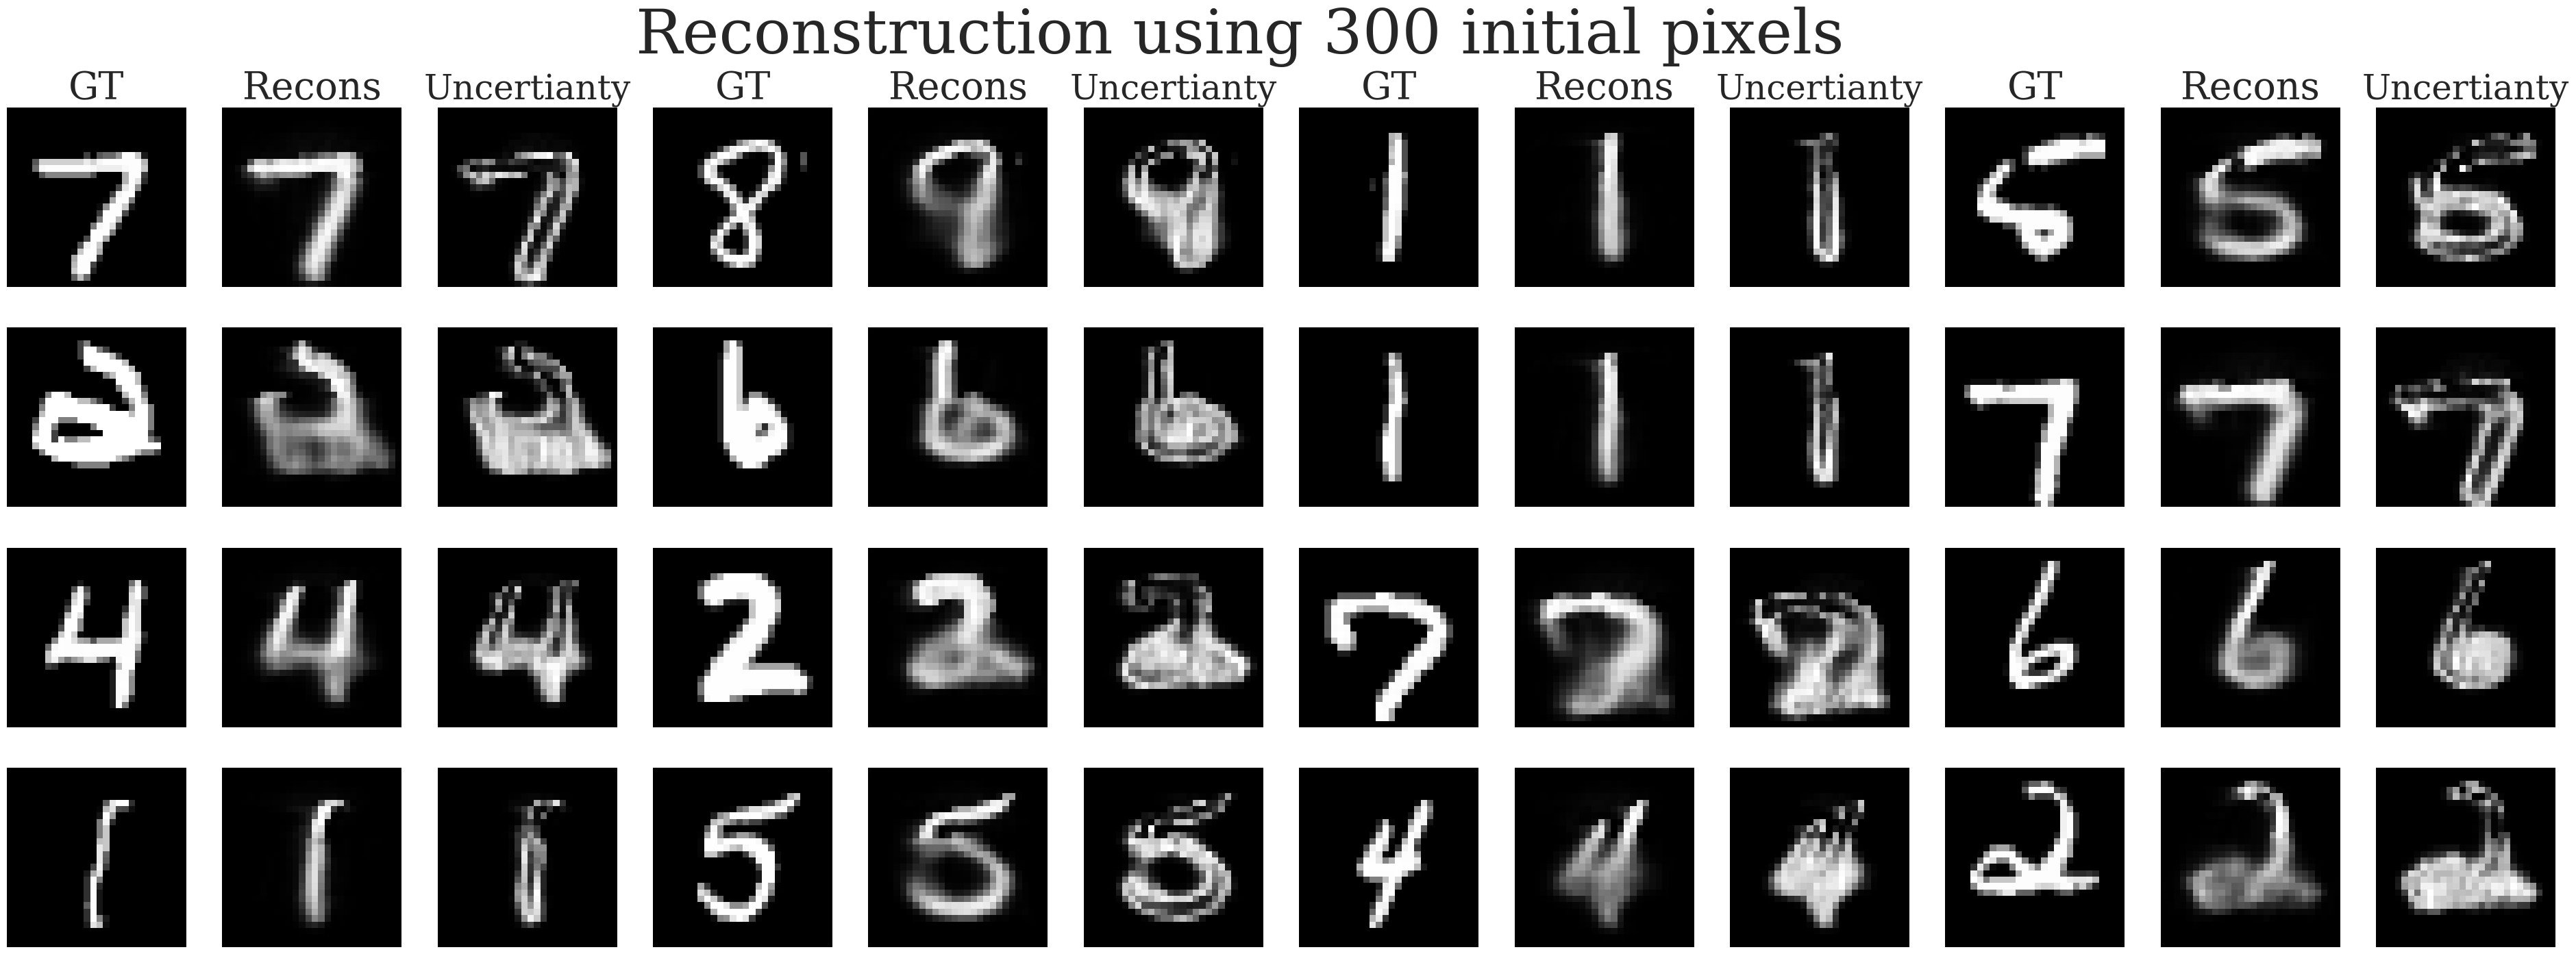

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertianty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertianty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

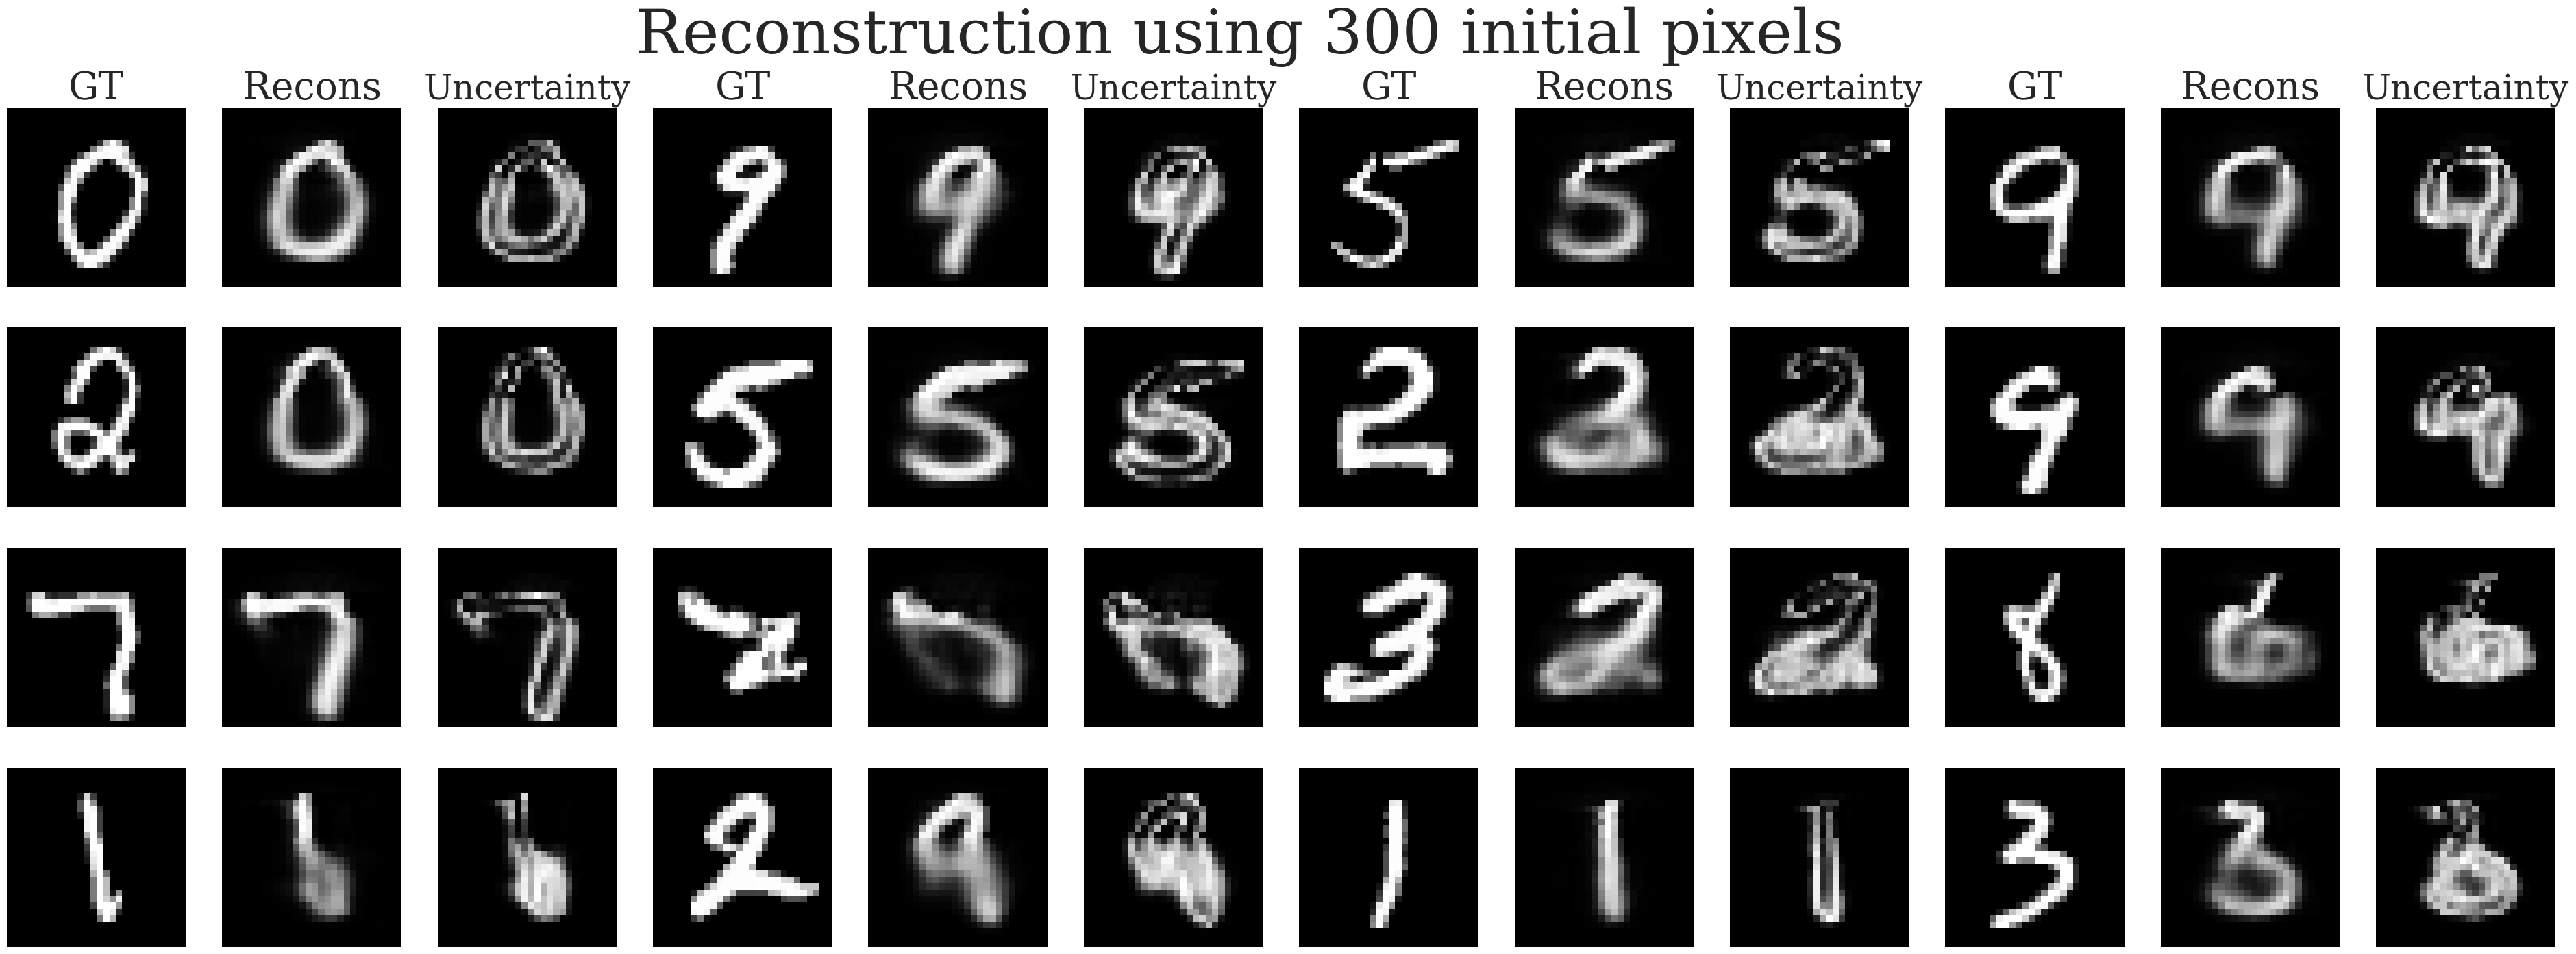

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True, constrained_layout=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65, y=0.97)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True, constrained_layout=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

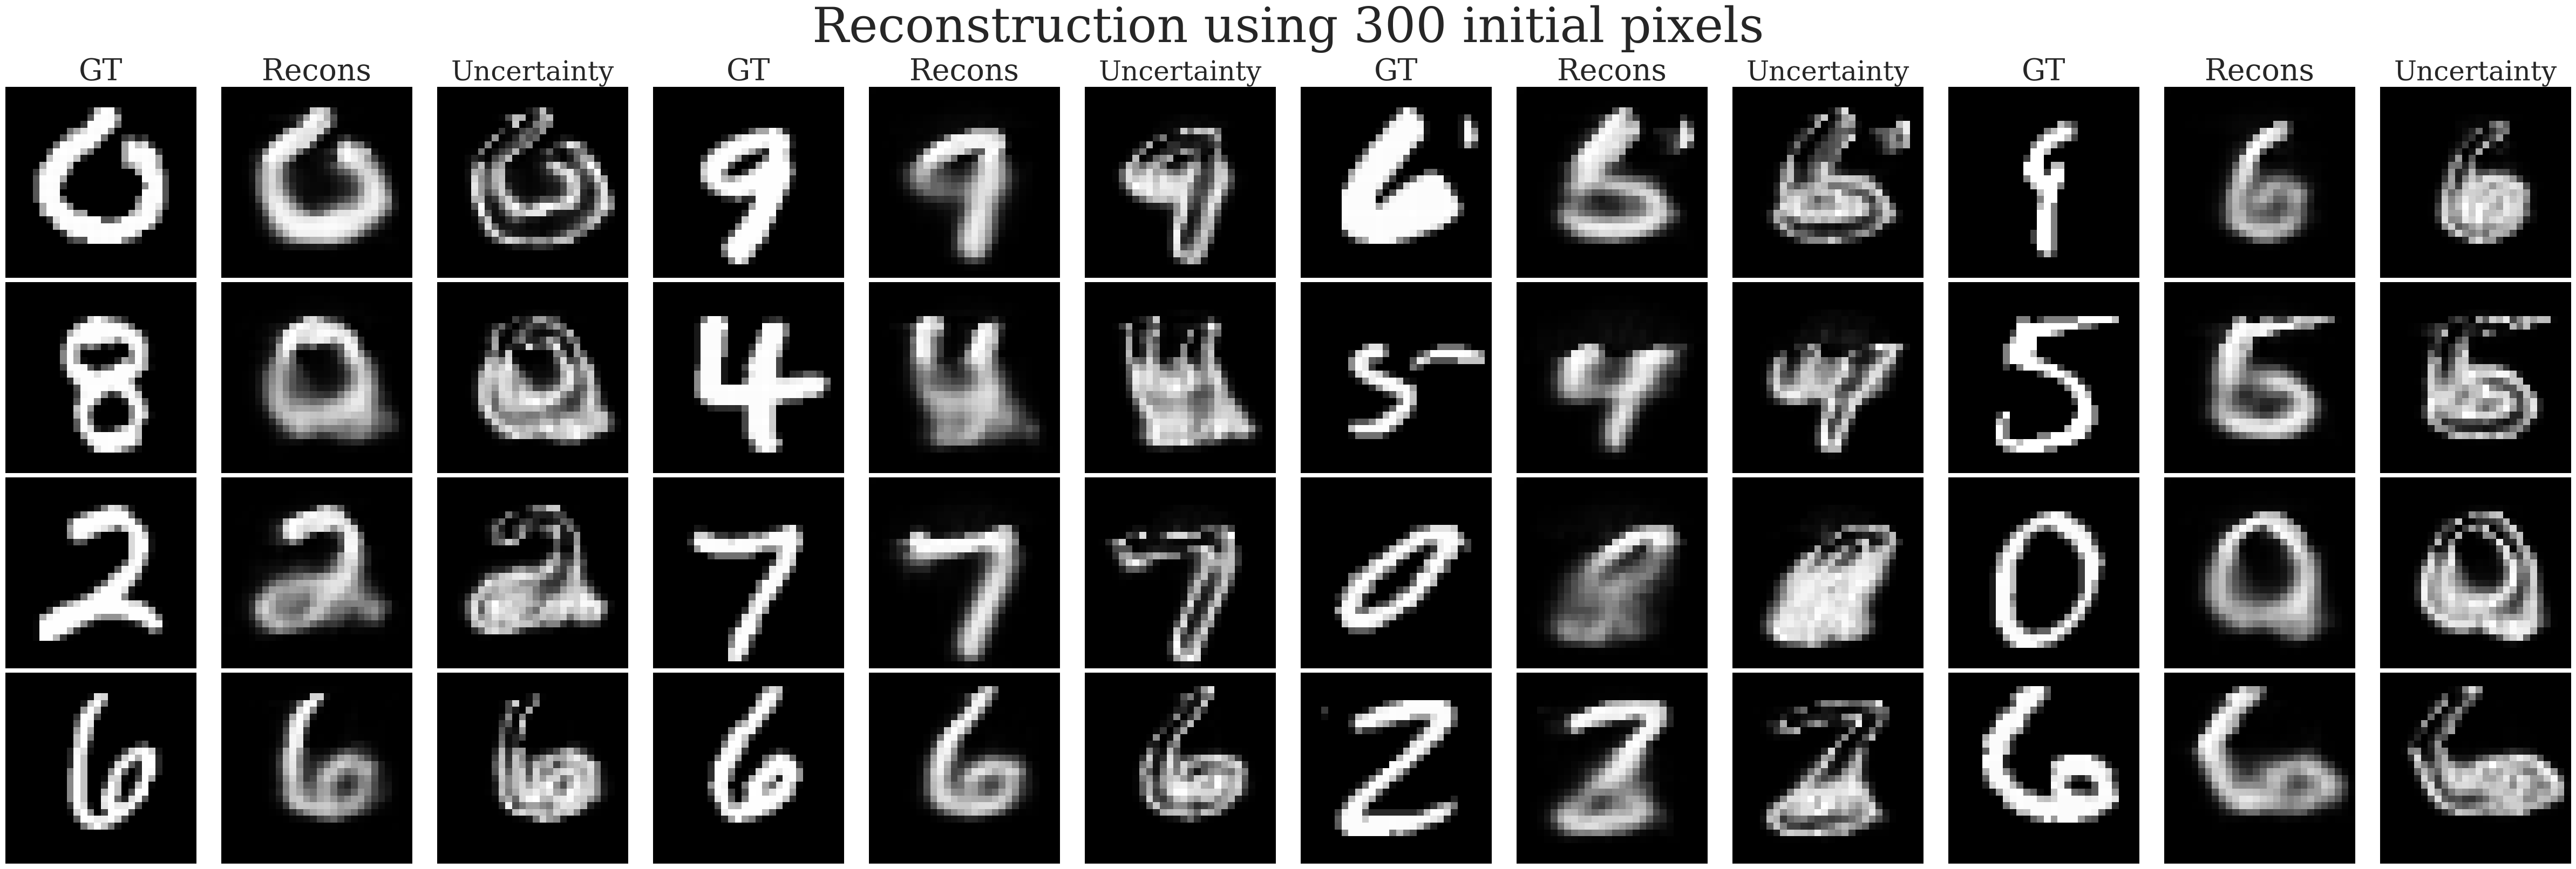

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not classification:
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True, constrained_layout=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    res = 28 // mini_res_mnist
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if run_mnist:
                axs[i, nb_cols*j].imshow(x.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if run_mnist:
                axs[i, nb_cols*j+1].imshow(x_recons.reshape((res, res)), cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if run_mnist and not use_mse_loss:
                x_uncert = xs_uncert[i*4+j]
                axs[i, nb_cols*j+2].imshow(x_uncert.reshape((res, res)), cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')